# 1. Load and imports

In [2]:
from eda import *
from pre_process import *
from topic_modeling import *
from percent import *
from adverbs_eda import *
from itertools import chain
from spacy.lang.fr.stop_words import STOP_WORDS as fr_stop
from sentence_transformers import SentenceTransformer
from transformers import FlaubertModel
from transformers import CamembertModel
from bertopic import BERTopic




import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import pickle
import plotly.express as px
import plotly.offline as pyo
import kaleido


pyo.init_notebook_mode()


In [3]:
%load_ext autoreload

%autoreload 2

In [4]:
pd.set_option('display.max_rows', 200)
pd.set_option("display.max_colwidth", -1)
pd.set_option('display.max_columns', 200)

In [5]:
df = pd.read_csv('./../../Data/Dataframes/eulogies.csv')

In [6]:
df = df[((df['Annee']>1793) & (df['Annee']<1832))|(df['Auteur'] =='Condorcet')]

# 2. First axis : basic statistics

## Removing \n, \t, non-useful spaces

In [7]:
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace("\\n", "").replace("\\t", "").replace("\n", "").replace("\t", "")
                               .strip())

In [8]:
df.head()

Savant     Auteur  Annee  \
0  Fontaine       Condorcet  1771    
1  Perrault       Condorcet  1773    
2  de la Chambre  Condorcet  1773    
3  Frenicle       Condorcet  1773    
4  Boyle          Condorcet  1773    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## a. Number of eulogies

In [9]:
print('There are ' + str(df.shape[0]) + ' eulogies') 
print('There are ' + str(df[df['Annee']<1793].shape[0]) + ' eulogies before the French Revolution')
print('There are ' + str(df[df['Annee']>=1793].shape[0]) + ' eulogies after the French Revolution')

There are 144 eulogies
There are 78 eulogies before the French Revolution
There are 66 eulogies after the French Revolution


In [10]:
df['Auteur'].nunique()

12

## b. Number of eulogies per year

array([[<AxesSubplot:title={'center':'Annee'}>]], dtype=object)

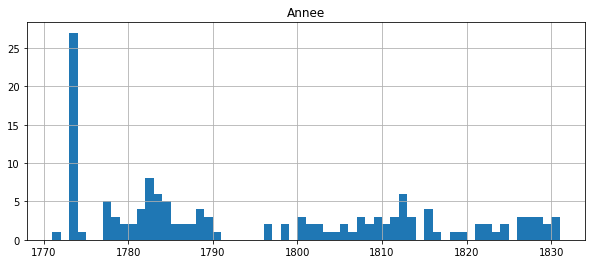

In [11]:
nbins = int(df['Annee'].max() - df['Annee'].min())
#nbins
df.hist('Annee', bins = nbins, figsize = (10,4))

In [12]:
df_help = df.groupby(['Annee'])['Savant'].count().reset_index().rename(columns = {'Savant' : 'count'})

df_pre = df_help[df_help['Annee']<=1793]
df_post = df_help[df_help['Annee']>1793]

In [13]:
from scipy.stats import ttest_ind

ttest_ind(df_pre['count'].array, df_post['count'].array)

Ttest_indResult(statistic=2.1043725964483397, pvalue=0.04096396730552059)

## b. Length of the eulogies

In [14]:
side_info(df)

df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('enfans', 'enfants').replace('instrumens', 'instruments')
                               .replace('talens', 'talents').replace('différens', 'différents').replace(
                               'monumens', 'monuments').replace('évènemens', 'évènements').replace('savans',
                                                                                                  'savants').
                               replace('documens', 'documents').replace('long-temps', 'longtemps'))

df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('†;', ';').replace('u?', 'ù').replace('¿', 'À')
                               .replace('∆', 'É').replace('∞', '°').replace('…', 'É').replace('¸','ü')
                               .replace('†:', ';').replace('†', ';'))

In [15]:
df['Weird'] = df['Eloge'].apply(lambda x : ''.join(char for char in x if not char.isalnum()).split())

In [16]:
df['Weird'].explode().value_counts()

,                                  47406
'                                  23200
’                                  20087
.                                  19129
;                                  8925 
-                                  2860 
:                                  2314 
',                                 1840 
’,                                 1719 
'.                                 788  
-,                                 623  
’.                                 514  
?                                  422  
--                                 208  
!                                  189  
-.                                 148  
(                                  122  
'-                                 91   
"                                  82   
)                                  81   
’'                                 61   
´                                  54   
’-                                 51   
'--                                51   
),              

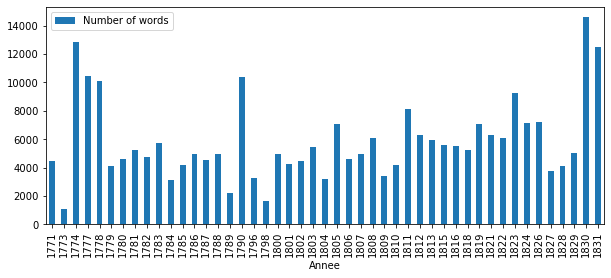

In [17]:
nbr_words_df = nbr_words(df, evol = True)

In [14]:
nbr_words_pre = nbr_words_df[nbr_words_df['Annee']<1793]
nbr_words_post = nbr_words_df[nbr_words_df['Annee']>=1793]

ttest_ind(nbr_words_pre['Number of words'].array, nbr_words_post['Number of words'].array)

Ttest_indResult(statistic=-0.20132239463632692, pvalue=0.8413537641053238)

## c. Average word length

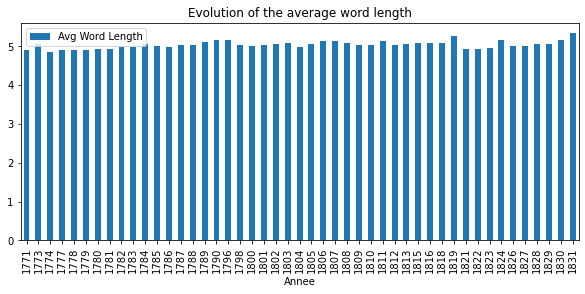

In [15]:
avg_words = avg_word_length(df, evol = True)

In [16]:
avg_words_pre = avg_words[avg_words['Annee']<=1793]
avg_words_post = avg_words[avg_words['Annee']>1793]

ttest_ind(avg_words_pre['Avg Word Length'].array, avg_words_post['Avg Word Length'].array)

Ttest_indResult(statistic=-3.525408520761012, pvalue=0.0009848974744641067)

## d. Average sentence length

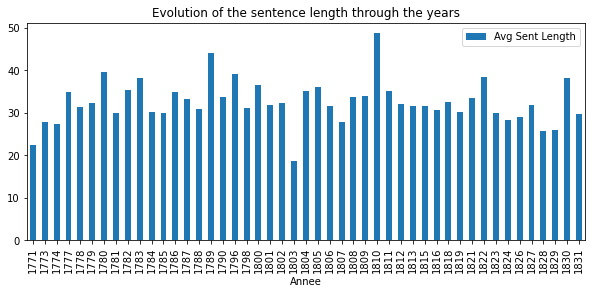

In [17]:
avg_sentence_df = avg_sentence(df, evol = True)

In [18]:
avg_sentence_pre = avg_sentence_df[avg_sentence_df['Annee']<1793]
avg_sentence_post = avg_sentence_df[avg_sentence_df['Annee']>=1793]

ttest_ind(avg_sentence_pre['Avg Sent Length'].array, avg_sentence_post['Avg Sent Length'].array)

Ttest_indResult(statistic=0.2340857959875094, pvalue=0.8159801235220829)

## e. Use of first person

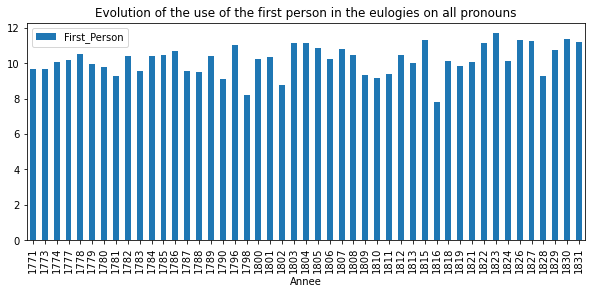

In [19]:
fst_person = first_person(df)

In [20]:
fst_person_pre = fst_person[fst_person['Annee']<1793]
fst_person_post = fst_person[fst_person['Annee']>=1793]

ttest_ind(fst_person_pre['First_Person'].array, fst_person_post['First_Person'].array)

Ttest_indResult(statistic=-1.3659039643825412, pvalue=0.17875724280276334)

## f. Use of modals

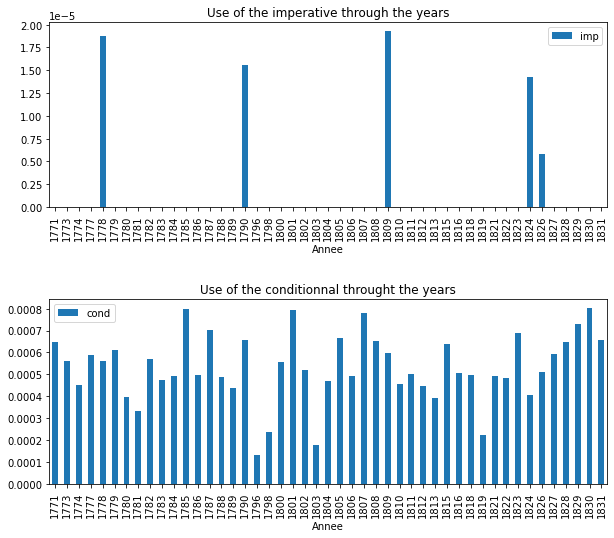

In [21]:
pci = cond_imperative(df)

In [22]:
c_adv = count_adverbs(df)

In [137]:
c_adv.sort_values(by = 'Number', ascending = False, inplace = True)
c_adv.reset_index(inplace = True)
c_adv.pop('index')
c_adv

Adverb  Number
0               plus    5933
1                 ne    5339
2                pas    3139
3                  n    2310
4             encore    1404
..               ...     ...
477    manifestement       1
478  mathmatiquement       1
479          mauvais       1
480     mcaniquement       1
481     vulgairement       1

[482 rows x 2 columns]

In [138]:
c_adv_pc = c_adv[c_adv['Number']>=5]
c_adv_pc['Categorie'] = 'default value'

- si loc 5
- que loc 52
- qu loc 83
- rien
- voilà 95
- voici 150
- minnement 183
- avec 196
- vice 220


In [139]:
c_adv_pc_old = pd.read_csv('./../../Data/Results/Adverbs.csv')

In [140]:
c_adv_pc['Assertivité'] = 'default value'

In [141]:
c_adv_tot = pd.merge(c_adv_pc, c_adv_pc_old, on = 'Adverb', how = 'left')

In [149]:
c_adv_tot.head()

Adverb  Number               Categorie    Assertivité    Temporalité
0    plus    5933                quantité  default value  default value
1      ne    5339                négation  default value  default value
2     pas    3139                négation  default value  default value
3       n    2310                négation  default value  default value
4  encore    1404  temps_quantité_logique  default value  default value

In [146]:
c_adv_tot.pop('Number_y')

0      5933
1      5339
2      3139
3      2310
4      1404
       ... 
252       5
253       5
254       5
255       5
256       5
Name: Number_y, Length: 257, dtype: int64

In [148]:
c_adv_tot.rename(columns = {'Number_x' : 'Number', 'Assertivité_y' : 'Assertivité', 'Categorie_y' : 'Categorie'},
                inplace = True)

In [175]:
c_adv_tot['Temporalité'] = 'default value'
c_adv_tot['Experience'] = 'default value'

In [150]:
c_adv_tot.to_csv('./../../Data/Results/Adverbs.csv', index=False)

In [188]:
modals = [x for x, y in zip(c_adv_pc['Adverb'], c_adv_pc['Categorie']) if 'modal' in y]
modals

['naturellement',
 'aisment',
 'malheureusement',
 'certainement',
 'apparemment',
 'clairement',
 'communment',
 'spcialement',
 'minemment',
 'vraisemblablement',
 'personnellement',
 'incomparablement']

In [186]:
df['Modals_adv'] =df['Eloge'].apply(lambda x : [word for word in x.split() if word in modals])

In [190]:
modals = df.groupby(['Annee'])['Modals_adv'].apply(list).reset_index()
modals.head()

Annee                                         Modals_adv
0   1741                                  [[naturellement]]
1   1742                          [[], [], [naturellement]]
2   1743  [[vraisemblablement], [vraisemblablement], [na...
3   1744                                               [[]]
4   1746                                               [[]]

In [192]:
modals['Modals_adv'] = modals['Modals_adv'].apply(lambda x : sum([len(ls) for ls in x]))


<AxesSubplot:xlabel='Annee'>

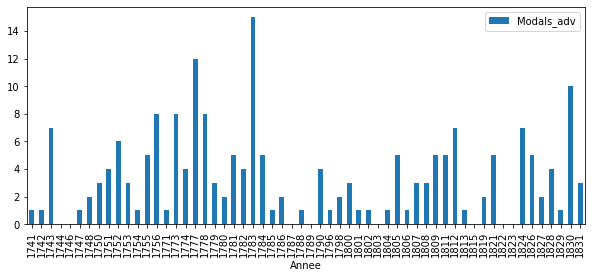

In [197]:
modals.plot('Annee', 'Modals_adv', kind = 'bar', figsize = (10,4))

## g. Use of past tenses

100%|███████████████████████████████████████| 144/144 [00:00<00:00, 3082.44it/s]


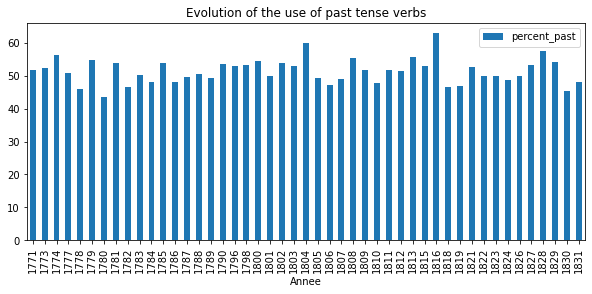

In [22]:
past_tense = past_tense(df)

In [23]:
past_tense_pre = past_tense[past_tense['Annee']<1793]
past_tense_post = past_tense[past_tense['Annee']>=1793]

ttest_ind(past_tense_pre['percent_past'].array, past_tense_post['percent_past'].array)

Ttest_indResult(statistic=-1.1382716668903345, pvalue=0.2610310346186218)

Reject Null Hypothesis the means are statistically different

## h. Starts with a statement on the birth

In [24]:
naissance(df)

In [25]:
df[df['naissance'] == False].shape[0]

51

In [26]:
df[(df['naissance'] == False)&(df['Annee']<1793)].shape[0]

16

In [27]:
df[(df['naissance'] == False)&(df['Annee']>=1793)].shape[0]

35

## i. Use of Proper Names


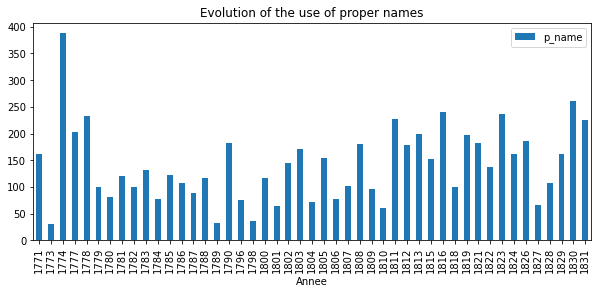

In [28]:
p_n = proper_name(df)

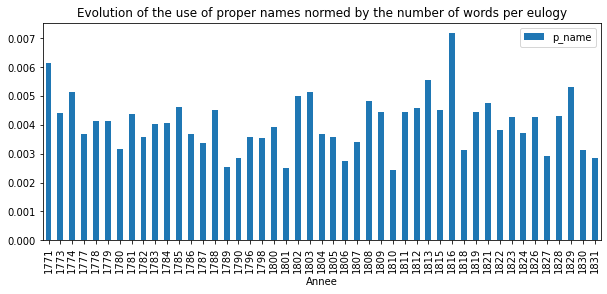

In [29]:
p_norm = proper_name(df, norm = True)

# 3. Second axis : Topic modeling

## Divide the dataframe into sentences

In [22]:
#https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe
def chainer(s):
    return list(chain.from_iterable(s.str.split('.')))

#Replace M. for Monsieur with M for the splitting
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('M.', 'M'))
lens = df['Eloge'].str.split('.').map(len)

# create new dataframe, repeating or chaining as appropriate
sent = pd.DataFrame({'Savant': np.repeat(df['Savant'], lens),
                    'Auteur': np.repeat(df['Auteur'], lens),
                     'Annee' : np.repeat(df['Annee'], lens),
                    'Eloge': chainer(df['Eloge'])})

sent = sent[(sent['Eloge'] != ' ') &  (sent['Eloge'] != '') & (sent['Eloge'].str.len()>10)]

In [174]:
# convert to list
df['Eloge'] = df['Eloge'].apply(lambda x : x.replace('M.', 'M'))

sent = df.copy()

#sent['Eloge'] = sent['Eloge'].str.replace(';', '.')
sent['Eloge'] = sent['Eloge'].str.replace('!', '.')
sent['Eloge'] = sent['Eloge'].str.replace('?', '.')
sent['Eloge'] = sent['Eloge'].str.split('.')

# convert list of pd.Series then stack it


In [175]:
sent = (sent
 .set_index(['Savant','Auteur','Annee'])['Eloge']
 .apply(pd.Series)
 .stack()
 .reset_index()
 .drop('level_3', axis=1)
 .rename(columns={0:'Eloge'}))

In [176]:
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité  
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait aucun

In [177]:
sent = sent[(sent['Eloge'] != ' ') &  (sent['Eloge'] != '') & (sent['Eloge'].str.len()>10)]

In [178]:
sent.shape

(17784, 4)

In [179]:
sent['Weird'] = sent['Eloge'].apply(lambda x : ''.join(char for char in x if not char.isalnum()).split())

In [180]:
#sent[['Weird']].explode(column = 'Weird').value_counts()

In [181]:
#sent[sent['Eloge'].str.contains("°")]['Eloge']

In [182]:
sent['Wrong'] = sent['Eloge'].apply(lambda x : x.count('?'))

In [183]:
sent['Wrong'].sum()

0

In [184]:
sent[(sent['Eloge'].str.contains('Condorcet'))&(sent['Annee']<1796)]

Savant     Auteur  Annee                  Eloge   Weird  Wrong
3173  Pascal  Condorcet  1778    (Page 133) Condorcet  [(, )]  0    
3198  Pascal  Condorcet  1778   ) Condorcet            [)]     0    
3211  Pascal  Condorcet  1778   ) Condorcet            [)]     0    
3224  Pascal  Condorcet  1778    235) Condorcet        [)]     0    
3237  Pascal  Condorcet  1778   ) Condorcet            [)]     0    
3251  Pascal  Condorcet  1778    (P 290) Condorcet     [(, )]  0    
3260  Pascal  Condorcet  1778   ) Condorcet            [)]     0    
3270  Pascal  Condorcet  1778   ) Condorcet            [)]     0    
3277  Pascal  Condorcet  1778   ) Condorcet            [)]     0    
3361  Pascal  Condorcet  1778    309) Condorcet        [)]     0    
3377  Pascal  Condorcet  1778   ) Condorcet            [)]     0    
3386  Pascal  Condorcet  1778    325) Condorcet        [)]     0    
3404  Pascal  Condorcet  1778    331) Condorcet        [)]     0    
3417  Pascal  Condorcet  1778   ) Condorcet            [)]     0    
3422  Pascal  Condorcet  1778    391) Condorcet        [)]     0    
3430  Pascal  Condorcet  1778    462) Condorcet        [)]     0    
3440  Pascal  Condorcet  1778    491) Condorcet        [)]     0

In [185]:
sent = sent[(sent['Eloge'].str.contains('Condorcet')==False)|(sent['Annee']>1796)].reset_index()
#sent.drop('index')
sent.shape

(17767, 7)

In [186]:
sent.drop(columns = ['index'])

Savant     Auteur  Annee  \
0      Fontaine   Condorcet  1771    
1      Fontaine   Condorcet  1771    
2      Fontaine   Condorcet  1771    
3      Fontaine   Condorcet  1771    
4      Fontaine   Condorcet  1771    
...         ...         ...   ...    
17762  Desmarets  Cuvier     1815    
17763  Desmarets  Cuvier     1815    
17764  Desmarets  Cuvier     1815    
17765  Desmarets  Cuvier     1815    
17766  Desmarets  Cuvier     1815    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Eloge  \
0      Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1       Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2       Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3       Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que d

In [187]:
#Preprocessing the sentences
rmv_sw(sent, name_col = 'Eloge')
rmv_punkt(sent)
lemmatize(sent, 'no_sw_no_punkt', 'tags')
rmv_digit(sent)

In [188]:
#Only keeping nouns and verbs to avoid noise
nouns_verbs(sent, 'Eloge_lem', adj = True)

In [189]:
#Removing stop words and really short words that might still be here
sent['n_v'] = sent['n_v'].apply(lambda x : ' '.join([elem for elem in x.split() if (elem not in fr_stop and 
                                                                                    len(elem)>2)]))

In [192]:
#sent.reset_index(inplace = True)
sent.drop('index', axis = 1, inplace = True)
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait 

## Embedding models

I tested different embedding models and chose to stay with the sentence transformer as it was the one working  the best

In [193]:
np.random.seed(123)

model_sent = SentenceTransformer('distiluse-base-multilingual-cased-v1')

#modelname = 'flaubert/flaubert_base_cased' 
#flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)

#camembert = CamembertModel.from_pretrained('camembert/camembert-base-wikipedia-4gb')

## Bertopic

In [194]:
#Loading Bertopic with embedding model chosen and nr_topics to auto so that topic with more than 0.9 similarity are
#merged
model = BERTopic(embedding_model = model_sent, min_topic_size=15,
                 nr_topics='auto',calculate_probabilities = True, n_gram_range = (1,2))

os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [195]:
topics, probabilities = model.fit_transform(sent.n_v)

In [141]:
with open("./../../Data/Results/topics", "wb") as fp:   #Pickling
    pickle.dump(topics, fp)
 
#with open("./../../Data/Results/topics", "rb") as fp:   # Unpickling
 #   topics = pickle.load(fp)


In [142]:
with open("./../../Data/Results/probabilities", "wb") as fp:   #Pickling
    pickle.dump(probabilities, fp)
    
    
#with open("./../../Data/Results/probabilities", "rb") as fp:   # Unpickling
 #   probabilities = pickle.load(fp)

In [196]:
df_rep = pd.DataFrame({'Topic': topics, 'Document': sent.Eloge_lem, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})

df_rep['Prob'] = df_rep.apply(lambda row : probabilities[row.name][row['Topic']], axis = 1)

In [197]:
df_rep['All_Probs'] = df_rep.apply(lambda row : probabilities[row.name], axis = 1)

df_rep['Scd_Topic'] = df_rep['All_Probs'].apply(lambda x : x.argsort()[-2])
df_rep['Fst_Topic'] = df_rep['All_Probs'].apply(lambda x : x.argsort()[-1])

In [198]:
df_same = df_rep[df_rep.apply(lambda x : x['Fst_Topic']==x['Scd_Topic'], axis=1)]

In [199]:
df_same.shape

(0, 10)

In [200]:
df_same = df_rep[df_rep.apply(lambda x : x['Fst_Topic']==x['Topic'], axis=1)]

In [201]:
df_same.shape

(6216, 10)

In [205]:
df_same.Fst_Topic.value_counts()

0     5262
6     71  
1     57  
2     55  
3     54  
12    43  
7     41  
4     39  
9     38  
5     34  
11    33  
14    31  
15    31  
19    31  
8     31  
18    29  
10    26  
22    24  
21    23  
23    19  
24    18  
29    18  
17    18  
27    18  
30    17  
16    17  
31    16  
28    16  
32    16  
20    15  
34    15  
13    15  
26    15  
33    15  
25    15  
Name: Fst_Topic, dtype: int64

In [202]:
df_27 = df_rep[df_rep['Topic']==27]


In [210]:
df_38 = df_rep[df_rep['Topic']==17]
df_38['Scd_Topic'].value_counts()

17    28
0     18
Name: Scd_Topic, dtype: int64

In [211]:
df_38['Fst_Topic'].value_counts()

0     28
17    18
Name: Fst_Topic, dtype: int64

In [203]:
df_27['Scd_Topic'].value_counts()

0     18
27    4 
Name: Scd_Topic, dtype: int64

In [204]:
df_27['Fst_Topic'].value_counts()

27    18
0     4 
Name: Fst_Topic, dtype: int64

In [159]:
df_27[df_27['Scd_Topic']==27].sort_values(by='Scd_Topic', ascending=False)

Topic  \
150    27      
1702   27      
16058  27      
15201  27      
15023  27      
13872  27      
13846  27      
13331  27      
13280  27      
13020  27      
10945  27      
10710  27      
10134  27      
9708   27      
7967   27      
7027   27      
4280   27      
3723   27      
3394   27      
16635  27      

                                                                                                                                                      Document  \
150    grand artiste vieillir génie perdu force|forces cacher                                                                                                    
1702   renoncer science calcul maitriser trop l esprit exiger temps force|forces s y livrer                                                                      
16058  le molécule solliciter simultanément force|forces égal diamétralement opposer repos tandis que l action d un onde unique avoir librement osciller         
15201  penser provenir résistance milieu éthéré mouvoir corps céleste                                                                                            
15023  force l âge d un dextérité égal                                                                                                                           
13872  Breguet remplacer force|forces élastique modérer constant exercer action d un manière simple                                                              
13846  le variation température rendre dimension force|forces élastique variable                                                                                 
13331  mais source c être Hauy non l avoir découvrir mesurer force l abondance                                                                                   
13280  par malheur apprendre bout bien temps effet passion humain laisser calculer aisément force|forces nature                                                  
13020  enfin âge diminution force|forces l obliger @card@ prendre retraire                                                                                       
10945  notre confrère entraîner séduisant recherche calculer force|forces                                                                                        
10710  Joseph doué d un force corps supérieur homme ordinaire                                                                                                    
10134  force|forces présence danger conserver l abandonner transporter connaissance maison l on pouvoir savoir qu au bout jour être l on devoir donner nouveau   
9708   coulomb imaginer chercher force résistance presque imperceptible fil flexible opposer main vouloir tordre                                                 
7967   force l âge moment entrevoir possibilité                                                                                                                  
7027   édifice munir danger redouter c être qu entre effort l homme borner force|forces nature jamais s établir qu un lutte inégal                               
4280   peine s apercevoir disposition qu il combattre force l autorité tendresse paternel trouver résistance                                                     
3723   n avoir force résister premier mouvement taire premier penser revenir premier idée donner œil autre l ordre liaison                                       
3394   tête perdu activité force|forces âme épuiser raison sain                                                                                                  
16635  vénérable vieillard être atteindre d un fièvre qui jour anéantir force|forces                                                                             

                                                                                                                                                                                                                                                       Eloge  \
150     Ce 

In [143]:
model.save('./../../Data/Results/bert_model')
#model = BERTopic.load('./../../Data/Results/bert_model')

/Users/clemencebarsi/miniconda3/envs/py385/lib/python3.8/site-packages/scipy/sparse/_index.py:124: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.



In [147]:
_ = sent_rep(27, df_rep)

 Ses forces l'abandonnérent de plus en plus


 Ces soins de lui-même n'ont jamais eu qu'un seu but, celui de réserver tout son temps et toutes ses forces pour les travaux de l'esprit


 Cette séparation était au-dessus des forces de notre confrère


 Pourquoi faut-il que les forces humaines restent inférieures devant les dons de l'intelligence 


 L’Hopital jugeait les obstacles, mais il sentait ses forces


 L’excès du travail, le moins dangereux, le plus excusable de tous, et celui dont l’effet est le plus lent, n’altéra point ses forces


 Il usa de toutes ses ressources pour échapper à des forces si supérieures aux siennes ; mais obligé d'en venir au combat, il se défendit avec autant de sang-froid que de courage


 Les fonctions de sa place, déjà peut-être supérieures à ses forces, étaient au-dessous de son zèle


 Le germe du caleul différentiel est dans Barrow celui des forces centrales dans Huyghens ; et Newton n'en reste pas moins l'honneur de l'esprit humain


 Mais le travai

In [206]:
df_info = model.get_topic_info()
df_info

Topic  Count  \
0  -1      9639    
1   0      5262    
2   1      436     
3   2      386     
4   3      225     
5   4      188     
6   5      143     
7   6      138     
8   7      112     
9   8      108     
10  9      107     
11  10     102     
12  11     95      
13  12     85      
14  13     78      
15  14     60      
16  15     59      
17  16     51      
18  17     46      
19  18     41      
20  19     40      
21  20     36      
22  21     36      
23  22     36      
24  23     32      
25  24     29      
26  25     24      
28  26     22      
27  27     22      
29  28     21      
30  29     19      
31  30     19      
32  31     19      
33  32     19      
34  33     17      
35  34     15      

                                                                      Name  
0   -1_faire_homme_pouvoir_grand                                            
1   0_card_science_faire_fil                                                
2   1_médecin_maladie_malade_médeciner                                      
3   2_astronome_astronomie_observation_astronomique                         
4   3_chimie_chimiste_substance_chimiquer                                   
5   4_génie_homme génie_homme_grand                                         
6   5_jeune_jeunesse_jeune homme_homme                                      
7   6_mémoire_souvenir_donner mémoire_rappeler                              
8   7_philosophe_philosophie_philosopher_goût                               
9   8_expérience_observation_confirmer_expérience faire                     
10  9_naturel_histoire naturel_nature_histoire                              
11  10_artiste_art_talent_savant artiste                                    
12  11_théorie_expérience_système_général                                   
13  12_religion_chrétien_religieux_dieu                                     
14  13_ministre_ministère_gouvernement_ennemi                               
15  14_année_dernier année_dernier_vie                                      
16  15_moi_mois moi_mois_dernier mois                                       
17  16_anatomie_histoire_description_naturel                                
18  17_force_force forces_forces_force force                                
19  18_horloge_horlogerie_penduler_perfection                               
20  19_matériau_matériaux matériau_matériaux_matériau matériau              
21  20_maréchal_colonel_croix_marquis                                       
22  21_abbé_abbé gua_gua_abbé picard                                        
23  22_cardinal_cardinal luynes_luynes_évêque                               
24  23_révolution_révolutionnaire_révolution annoncer_existence révolution  
25  24_temps_temps temps_instant_rester temps                               
26  25_professeur_élève_choix_doctrine                                      
28  26_nuage_ciel_météorologie_région                                       
27  27_solution_problème_résoudre_méthode                                   
29  28_fruit_fruit travail_découvrir fruit_travail                          
30  29_poésie_poète_goût_paradis                                            
31  30_voir_observer_observation_obtenir monsieur                           
32  31_cour_cours_cours cour_cour cour                                      
33  32_banks_banks faire_banquier_faire                                     
34  33_latin_langue_écrire_français                                         
35  34_géomètre_travail_géomètre occuper_géographe

## Hierarchical clustering

In [84]:
#11, 27, 29, 33, 38 39, 41
topic_medecine = [3]
topic_ciel = [4, 42]
topic_vie = [1, 2, 10, 18, 20, 34, 44]
topic_temps = [32]
topic_biologie = [4, 8, 41]
topic_geologie = [5]
topic_chimie = [7]
topic_politique = [8, 17, 25]
topic_philosophie = [13, 31]
topic_physique = [23]
topic_qualite = [9]
topic_maths = [6, 43]
topic_methode = [12, 14, 19, 21, 26, 35, 27]
topic_religion = [15]
topic_memoire = [16, 22]
topic_horloge = [24]
topic_perso = [28, 30, 40]

In [85]:
topic_dict = {'medecine' : topic_medecine, 'geologie' : topic_geologie, 'vie' : topic_vie, 
             'politique' : topic_politique,  'religion' : topic_religion, 
              'ciel' : topic_ciel, 'qualite' : topic_qualite, 'memoire' : topic_memoire, 'chimie' : topic_chimie,
             'biologie' : topic_biologie, 'philosophie' : topic_philosophie, 'archi' : topic_archi,
             'methode' : topic_methode, 'perso' : topic_perso, 'physique' : topic_physique,
             'maths' : topic_maths, 'horloge' : topic_horloge}
#'ouvrage' : topic_ouvrage,

In [86]:
#higher topics

topic_science = (topic_ciel + topic_chimie + topic_biologie + topic_archi + topic_philosophie + topic_physique
                + topic_maths + topic_medecine + topic_geologie + topic_horloge)
topic_personne = topic_vie + topic_qualite + topic_perso
topic_posterite = topic_memoire 
topic_societe = topic_religion + topic_politique
topic_theorie = topic_methode

In [87]:
'''

#0, 1,
#Manually creating topics
topic_discipline = [4,5,7,10,15,19,22,25,26]
topic_element = [2,3,6,16,18,31]
topic_vie = [0,1,12, 13, 20, 27, 32]
topic_politique = [8,17,29,33,34]
#topic_ouvrage = []
topic_voyage = [21, 30]
topic_religion = [14]
topic_qualite = [11,24,28]
topic_memoire = [9,23]
topic_dict = {'discipline' : topic_discipline, 'element' : topic_element, 'vie' : topic_vie, 
             'politique' : topic_politique,  'religion' : topic_religion, 
              'voyage' : topic_voyage, 'qualite' : topic_qualite, 'memoire' : topic_memoire}
#'ouvrage' : topic_ouvrage,
'''

"\n\n#0, 1,\n#Manually creating topics\ntopic_discipline = [4,5,7,10,15,19,22,25,26]\ntopic_element = [2,3,6,16,18,31]\ntopic_vie = [0,1,12, 13, 20, 27, 32]\ntopic_politique = [8,17,29,33,34]\n#topic_ouvrage = []\ntopic_voyage = [21, 30]\ntopic_religion = [14]\ntopic_qualite = [11,24,28]\ntopic_memoire = [9,23]\ntopic_dict = {'discipline' : topic_discipline, 'element' : topic_element, 'vie' : topic_vie, \n             'politique' : topic_politique,  'religion' : topic_religion, \n              'voyage' : topic_voyage, 'qualite' : topic_qualite, 'memoire' : topic_memoire}\n#'ouvrage' : topic_ouvrage,\n"

In [88]:
high_dict = {'science' : topic_science, 'personne' : topic_personne, 'posterite' : topic_posterite,
                                                                          'societe' : topic_societe,
            'theorie' : topic_theorie}

In [89]:
model.visualize_hierarchy()

In [90]:
df_plot = df_info.copy()
df_plot['High_High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, high_dict)[1])
df_plot['High_Topic'] = df_plot['Topic'].apply(lambda x : major_topic(x, topic_dict)[1])
df_plot = df_plot[df_plot['High_Topic']!='outlier']
df_plot['Phrase'] = df_plot['Topic'].apply(lambda x : sent_rep(x, df_rep, print_=False).Eloge.tolist())
df_plot = df_plot.explode('Phrase')

fig = px.icicle(df_plot, path=[px.Constant("all"), 'High_High_Topic', 'High_Topic', 'Name', 'Phrase'])
fig.update_traces(root_color="lightgrey")
fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
fig.show()
fig.write_html('./../../Data/Results/hierarchy.html')

## Topics over time

In [92]:
#with open("./../../Data/Results/topics", "rb") as fp:   # Unpickling
 #   topics = pickle.load(fp)
    

df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})
df_top.head()

Topic  \
0  0       
1 -1       
2 -1       
3 -1       
4  3       

                                                                                                                                                                                                                                                                                                                                                   Document  \
0  naître année card                                                                                                                                                                                                                                                                                                                                          
1  père mourir                                                                                                                                                                                                                                                                                                                                                
2  parent vouloir étude droit nécessaire exercer charge styler barbare commentateur loi romain enthousiasme servile dégoûter homme nature destiner trainer                                                                                                                                                                                                    
3  rigueur esprit démonstration satisfaire donner goût exclusif science exact sensible plaisir démèler débris ancien loi romain rester sagesse sénat loi pouvoir œil amas décision fonder raison passion législateur préjuger siècle considération acheter charge flatter homme prétendre donner talent envie appeler chose jeune homme instinct médiocrité   
4  tourmenter sollicitation parent activité génie province offrir aliment venir chercher repos objet occupation                                                                                                                                                                                                                                               

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                         

In [93]:
df_top[df_top['Topic']==12]

Topic  \
9      12      
62     12      
152    12      
160    12      
165    12      
257    12      
278    12      
304    12      
363    12      
367    12      
441    12      
483    12      
491    12      
533    12      
641    12      
721    12      
799    12      
1290   12      
1661   12      
1762   12      
1817   12      
1912   12      
1935   12      
2085   12      
2089   12      
2094   12      
2099   12      
2103   12      
2188   12      
2571   12      
2725   12      
2929   12      
3040   12      
3043   12      
3190   12      
3305   12      
3798   12      
4154   12      
4183   12      
4332   12      
4597   12      
4699   12      
4700   12      
4701   12      
4735   12      
4736   12      
4823   12      
4841   12      
4844   12      
4857   12      
4866   12      
4916   12      
4960   12      
5035   12      
5074   12      
5265   12      
5291   12      
5332   12      
5348   12      
5393   12      
5398   12      
5411   12      
6070   12      
6077   12      
6158   12      
6194   12      
6569   12      
6640   12      
6677   12      
6929   12      
7110   12      
7124   12      
7137   12      
7160   12      
7530   12      
7607   12      
7832   12      
8103   12      
8274   12      
8556   12      
8782   12      
8783   12      
8807   12      
8809   12      
8835   12      
9125   12      
9192   12      
9271   12      
9418   12      
9457   12      
9551   12      
10149  12      
10245  12      
10426  12      
10689  12      
10705  12      
10827  12      
10854  12      
11280  12      
11334  12      
11421  12      
11431  12      
11442  12      
11453  12      
11733  12      
11964  12      
12446  12      
12890  12      
13340  12      
13471  12      
13636  12      
13764  12      
13827  12      
13976  12      
14206  12      
14575  12      
14749  12      
14953  12      
15151  12      
15189  12      
15195  12      
15209  12      
15262  12      
15290  12      
15340  12      
15562  12      
15651  12      
15683  12      
15694  12      
15723  12      
15748  12      
16205  12      
16207  12      
16215  12      
16482  12      
16537  12      
16559  12      
16585  12      
16653  12      
16686  12      
16710  12      
17162  12      
17291  12      
17490  12      
17641  12      
17646  12      

                                                                                                                                                                                                                                                                                                       Document  \
9      nature donner imagination ardent esprit hardi élever pouvoir réputation certitude compter admirateur jésuite éteindre inquiétude difficile production génie élever grand chose vrai sens|sen sen talent ennemi dangereux prôneur                                                                           
62     homme génie éprouver besoin faire partager sentiment forcer avidité cesse renaître jouir jour succès veiller préparer lendemain vouloir maitriser opinion publique dépendre sentiment devoir pouvoir appeler faiblesse faiblesse été utile homme                                                           
152    génie inspirer vierge inspirer dessin                                                                                                                                                                                                                                                                      
160    homme sage génie pousser tenter chose hardi rester oser                                                                                                                                                                                                                                                    
165    jour venir écrire homme génie rester servir constater gloire                                                    

In [94]:
df_top['Words'] = df_top['Topic'].apply(lambda x : df_info[df_info['Topic']==x].reset_index()['Name'][0])
df_top['Words'] = df_top['Words'].apply(lambda x : ', '.join(x.split('_')[1:]))

In [95]:
#Normalize by number of sentences

topics_over_time_norm = df_top.groupby(['Annee', 'Topic', 'Words'])['Eloge'].count().reset_index()
topics_over_time_norm.rename(columns = {'Annee' : 'Timestamp', 'Eloge' : 'Frequency'}, inplace = True)

topics_over_time_norm.head()

Timestamp  Topic                                  Words  Frequency
0  1771      -1      faire, homme, pouvoir, grand           75       
1  1771       0      card, science, animal, acide           16       
2  1771       1      médecin, maladie, malade, médeciner    1        
3  1771       3      fil, père, fils fil, fil fil           2        
4  1771       4      jardin, botanique, planter, botaniste  2

In [96]:
df_by_year = df.groupby('Annee')['Eloge'].count().reset_index()
sent_by_year = sent.groupby('Annee')['Eloge'].count().reset_index()

In [97]:
sent_topic_time = topics_over_time_norm.copy()

topics_over_time_norm = pd.merge(topics_over_time_norm, df_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')
topics_over_time_norm.head()

Timestamp  Topic                                  Words  Frequency  Annee  \
0  1771      -1      faire, homme, pouvoir, grand           75         1771    
1  1771       0      card, science, animal, acide           16         1771    
2  1771       1      médecin, maladie, malade, médeciner    1          1771    
3  1771       3      fil, père, fils fil, fil fil           2          1771    
4  1771       4      jardin, botanique, planter, botaniste  2          1771    

   Eloge  
0  1      
1  1      
2  1      
3  1      
4  1

In [98]:
sent_topic_time = pd.merge(sent_topic_time, sent_by_year, left_on = 'Timestamp', right_on = 'Annee', 
                                how = 'left')

In [99]:
topics_over_time_norm['Frequency'] = topics_over_time_norm.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
topics_over_time_norm.pop('Eloge')
topics_over_time_norm.pop('Annee')

sent_topic_time['Frequency'] = sent_topic_time.apply(lambda row : row['Frequency']/row['Eloge'],
                                                                axis = 1)
sent_topic_time.pop('Eloge')
sent_topic_time.pop('Annee')

0       1771
1       1771
2       1771
3       1771
4       1771
        ... 
1225    1831
1226    1831
1227    1831
1228    1831
1229    1831
Name: Annee, Length: 1230, dtype: int64

In [100]:
bins = sent.Annee.unique().shape[0]
topics_over_time = model.topics_over_time(sent.n_v, topics, sent.Annee, nr_bins=bins)
topics_over_time

Topic  \
0    -1       
1     0       
2     1       
3     3       
4     4       
...  ..       
1067  37      
1068  40      
1069  41      
1070  42      
1071  44      

                                                                                               Words  \
0     homme, géométrie, faire, donner, méchanceté                                                      
1     card, imprimer card, imprimer, petit, recueil                                                    
2     nature absurde, regarder douleur, absurde plaindre, douleur mourir, mourir suite                 
3     adresser secours, secours conseil, offrir aliment, génie province, province offrir               
4     cultiver capital, anel diminuer, goût agriculture, diminuer aversion, naturel affaire            
...                                                                                     ...            
1067  paratonnerre conséquence, paille divergent, divergent instant, conséquence immédiat, divergent   
1068  professeur, professeur légitime, professeur vif, parure autorité, professeur reparaître          
1069  intéressant résultat, donner intéressant, épreuve donner, insecte soumettre, soumettre épreuve   
1070  succès manquer, chose parfait, entrevoir chose, parfait genre, satisfaire entrevoir              
1071  architecte, moderne célèbre, plupart phare, fameux architecte, port plupart                      

      Frequency  Timestamp  
0     75         1770.940   
1     16         1770.940   
2     1          1770.940   
3     2          1770.940   
4     2          1770.940   
...  ..               ...   
1067  2          1829.723   
1068  4          1829.723   
1069  1          1829.723   
1070  2          1829.723   
1071  1          1829.723   

[1072 rows x 4 columns]

In [101]:
#Normalized by number of sentences


model.visualize_topics_over_time(sent_topic_time)

In [102]:
#Normalized by number of eulogies

model.visualize_topics_over_time(topics_over_time_norm)

In [60]:
df[df['Annee']>=1829]

Savant   Auteur  Annee  \
131       Laplace  Fourier   1829   
132          Bosc   Cuvier   1829   
133  Humphry Davy   Cuvier   1830   
134       Fresnel    Arago   1830   
135         Volta    Arago   1831   

                                                 Eloge  \
131  Messieurs, Le nom de Laplace a retenti, dans t...   
132  Louis-Augustin Guillaume Bosc, longtemps connu...   
133  Un célèbre académicien, parvenu de l'état le p...   
134  Messieurs, " il est des hommes à qui l'on succ...   
135  Messieurs, L'ambre jaune, lorsqu'il a été frot...   

                                             Side_Info  First_Person  \
131  [M, le marquis de Pastoret., M. Royer-Collard....      9.954338   
132  [Paul Bose d'Antic, né en 1726 à Pierre-Ségude...     11.501080   
133  [Researches chemical and philosophical ; chief...     10.610551   
134                                                 []     12.139690   
135  [Le 6 août 1753, On sait aujourd'hui que l'exp...     11.224301   

                                                  tags  imp      cond  
131  [(Messieurs, NOM, messieurs), (,, PUN, ,), (Le...  0.0  0.001060  
132  [(Louis-Augustin, NAM, Louis-Augustin), (Guill...  0.0  0.000403  
133  [(Un, DET:ART, un), (célèbre, ADJ, célèbre), (...  0.0  0.000425  
134  [(Messieurs, NOM, messieurs), (,, PUN, ,), (",...  0.0  0.001177  
135  [(Messieurs, NOM, messieurs), (,, PUN, ,), (L'...  0.0  0.000657

In [144]:
for sentence, topic in df_sent['Tuple_topic_sent'][131]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)


 -1_homme_faire_pouvoir_donner   --->Messieurs, Le nom de Laplace a retenti, dans tous les lieux du monde où les sciences sont honorées : mais sa mémoire ne pouvait recevoir un plus digne hommage que le tribut unanime de l'admiration et des regrets du corps illustre dont il a partagé les travaux et la gloire
 -1_homme_faire_pouvoir_donner   ---> Il a consacré sa vie à l'étude des plus grands objets qui puissent occuper l'esprit humain
 -1_homme_faire_pouvoir_donner   ---> Les merveilles du ciel, les hautes questions de la philosophie naturelle, les combinaisons ingénieuses et profondes de l'analyse mathématique, toutes les lois de l'univers, ont été présentes à sa pensée pendant plus de soixante années, et ses efforts ont été couronnés par des décou vertes immortelles On remarqua, dès ses premières études, qu'il était doué d'une mémoire prodigieuse : toutes les occupations de l'esprit lui étaient faciles
 23_langue_traduction_langage_dictionnaire   ---> Il acquit rapidement une instruc

In [147]:
for sentence, topic in df_sent['Tuple_topic_sent'][135]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)

 2_planter_plante_espèce_jardin   --->Messieurs, L'ambre jaune, lorsqu'il a été frotté, attire vivement les corps légers, tels que des barbes de plumes, des brins de paille, de la sciure de bois
 -1_homme_faire_pouvoir_donner   ---> Théophraste, parmi les Grecs, Pline, chez les Romains, citèrent déja cette propriété, mais sans paraître y attacher plus d'importance qu'à un simple accident de forme ou de couleur
 -1_homme_faire_pouvoir_donner   ---> Ils ne se doutèrent pas qu'ils venaient de toucher au premier anneau d'une longue chaine de découvertes ; ils méconnurent l'importance d'une observation qui, plus tard, devait fournir des moyens assurés de désarmer les nuées orageuses, de conduire, dans les entrailles de la terre, sans danger et même sans explosion, la foudre que ces nuées recèlent
 3_air_rayon_sel_eau   ---> Le nom grec de l'ambre, électron, a conduit au mot électricité, par lequel on désigna d'abord la puissance attractive des corps frottés
 0_science_fil_père_homme   ---> 

- Topic 0, pic en 1830
- Augmentation des plantes après 1800 topic 1
- Moins de parler sur la famille entre 1790 et 1810 topic 3
- Euler plus mentionné avant rev 2 pics en 1773 et 1785 topic 8
- Pic pour géométrie en 1773 topic 14
- Théorie, expérience explication plus évoqué à partir de 1820 topic 28
- Médecine plus évoqué pré revolution pic en 1827-1828 topic 4
- Astronomie plus évoquée post révolution
- Pierre, montagne, rocher trps évoqué de 1818 à 1823 topic 6
- Air, sel, gaz, alcali beaucoup plus évoqué post rev pic en 1830 topic 7
- Chimie légèrement plus évoquée dans les années 20 topic 11
- Prince, roi, condé plus évoquée pre rev avec pic juste après 1815
- Philosophie plus évoquée avant la révolution topic 15
- Rayon, lumière, rayer pic en 1830 topic 18
- Ministère plus évoquée pre-rev pic en 1790 topic 19
- Professeur beaucoup plus évoqué post-rev pic topic 20
- Religion beaucoup plus évoquée pre-rev topic 21
- Expérience, confirmer, Mariotte, faire pic en 1830 topic 22
- Ile, vaisseau, baks, capitaine plus évoqué post rev topic 23
- Pic pour anatomie entre 1800 et 1805 topic 25
- Jeunesse age plus évoqué post rev topic 32
- Pic de langue traduire entre 1785 et 1790 topic 34
- Pic pour voyage entre 1815 et 1820 topic 37
- Horloge plus évoquée après 1808 pic en 1809 et 1827
- Pic pour marquis maréchal en 1787-1788 topic 48
- Pic pour loi, peuple nation en 1779 et 1790 topic 9
- Pic pour électricité tonnerre analogie en 1830 topic 43
- Topic impôt peuple natino disparaît après 1805 pic en 1776 et 1790
- Topic Révolution beaucoup plus évoqué avant 1805 pic en 1790 et 1805

- Pic en 1776 et augmentation de 1787 à 1790 du topic 38 impôt et plus mentionner à partir de 1806
- Pic en 1790, en 1805 pour topic révolution et après relativement constant 36
- Pic en 1830 pour électricité tonnerre 41
- Pic en 1776 pour topic 21 pour loi peuple nation et en 1790
- Pic en 1810 pour 35 horloge et augmentation après 1812
- Pic en 1805 pour 26 anatomie
- Religion beaucoup plus mentionnée avant 1793, pic en 1778 et 1790
- Topic 24 sur ministère plus mentionnée avant 1793, reste mentionné après mais moins
- Pic 1830, 23 expérience confirmer répéter
- Pic 1813 ile, vaisseau 20
- Pic 1830, 19 rayon lumière rayer
- Topic 17 philosophie beaucoup plus mentionné pré-révolution
- Topic 16 professeur école colège beaucoup plus mentionné post-révolution
- Topic 14 beaucoup plus mentionné pré 1780, petit pic dans les fins des années 1820
- Plusieurs pics, topic 13 pierre rocher volcan
- Pic 1830, air sel gaz topic 8
- Médecine plus mentionnée pré-rev pic fin des années 1820
- Topic 3 astronomie plus mentionné post-révolution
- TOpic 37 homme vanité plus mentionné avant révolution
- Topic 28 plus mentionné post-rev
- TOpic 15 pic en 1790, 1804, 1830







## Structure of an eulogy

In [134]:
df_top = pd.DataFrame({'Topic': topics, 'Document': sent.n_v, 'Eloge' : sent.Eloge, 'Annee' : sent.Annee,
                      'Savant' : sent.Savant, 'Auteur' : sent.Auteur})
df_top.head()

NameError: name 'topics' is not defined

In [97]:
df_top['Topic'] = df_top['Topic'].apply(lambda x :(x,  df_info[df_info['Topic']==x].reset_index()['Name'][0]))

In [98]:
df_top['High_High_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], high_dict))

In [99]:
df_top['Higher_Topic'] = df_top['Topic'].apply(lambda x : major_topic(x[0], topic_dict))

In [100]:
#df_top.to_csv('./../../Data/Results/df_with_topic.csv', index = False)
#df_top = pd.read_csv('./../../Data/Results/df_with_topic.csv')

In [101]:
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait 

In [102]:
sent['Eloge'][0]

'Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705'

In [103]:
df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['Topic']), axis = 1)
#df_top['Tuple_topic_sent'] = df_top.apply(lambda row : (row['Eloge'], row['High_High_Topic']), axis = 1)

reconstruct = df_top.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_topic_sent'].apply(list).reset_index()
df_sent = df.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
df_sent['Eloge'] = df_sent['Eloge'].str.replace('!', '.')
df_sent['Eloge'] = df_sent['Eloge'].str.replace('?', '.')
df_sent['Eloge'] = df_sent['Eloge'].apply(lambda x : x.split('.'))
df_sent['Tuple_topic_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_topic_sent'], 
                                                                         key=lambda x: row['Eloge'].index(x[0])),
                                                               axis = 1)

In [104]:
colors = []
for i in range(0, 16):
    for j in range(0, 16):
        code = str(i * 16 + j)
        #sys.stdout.write(u"\u001b[38;5;" + code + "m " + code.ljust(4))
        colors.append(u"\u001b[38;5;" + code + "m ")
    #print(u"\u001b[0m")

In [105]:
for sentence, topic in df_sent['Tuple_topic_sent'][2]:
    #print(colors[3*topic] + df_info.loc[topic+1]['Name'] + '  --->' + sentence)
    print(colors[3*topic[0]] + topic[1] + '   --->' + sentence)

 0_card_faire_science_donner   --->  Marin Cureau de la Chambre, médecin ordinaire du roi, naquit au Mans vers 1613
 0_card_faire_science_donner   ---> Le chancelier Séguier se l’attacha, moins pour son habileté dans la médecine, que pour l’étendue et la variété de Ses connaissances
 6_ministre_ministère_gouvernement_ennemi   ---> La confiance de ce ministre fournissait à la Chambre le moyen d’être utile aux gens de lettres, et il en saisissait avidement toutes les occasions
 0_card_faire_science_donner   ---> Il était bien éloigné de dédaigner les Sciences après avoir fait fortune par elles : espèce d’ingratitude qui n’est malheureusement que trop commune
 0_card_faire_science_donner   ---> Le cardinal de Richelieu lui donna une place dans l’Académie française, lors de Son établissement en 1635, et le chargea, en 1640, de répondre au livre de Hersant, en faveur des prétentions de la cour de Rome
 -1_faire_homme_pouvoir_grand   ---> Ce livre fut regardé en France comme séditieux, et l’

## Percent of topic per range 

In [106]:
def organise_topic(df, eloge = 'Eloge', topic = 'Topic', major = df):
    df['Tuple_' + topic + '_sent'] = df.apply(lambda row : (row[eloge], row[topic]), axis=1)
    
    reconstruct = df.groupby(['Savant', 'Auteur', 'Annee'])['Tuple_' + topic + '_sent'].apply(list).reset_index()
    
    df_sent = major.merge(reconstruct, on = ['Savant', 'Annee', 'Auteur'])
    df_sent['Eloge'] = df_sent['Eloge'].str.replace('!', '.')
    df_sent['Eloge'] = df_sent['Eloge'].str.replace('?', '.')
    df_sent[eloge] = df_sent[eloge].apply(lambda x : x.split('.'))
    df_sent['Tuple_'+topic+'_sent'] = df_sent.apply(lambda row :sorted(row['Tuple_'+topic+'_sent'], 
                                                                         key=lambda x: row[eloge].index(x[0])),
                                                               axis = 1)
    df_sent['Topic_Ordered'] = df_sent['Tuple_'+topic+'_sent'].apply(lambda x : [elem[1] for elem in x])
    return df_sent

In [107]:
df_sent_t = organise_topic(df_top)
df_sent_h = organise_topic(df_top, topic ='Higher_Topic')
df_sent_hh = organise_topic(df_top, topic ='High_High_Topic')

## By higher topic

144it [00:00, 23430.96it/s]
78it [00:00, 20350.57it/s]
66it [00:00, 19708.39it/s]


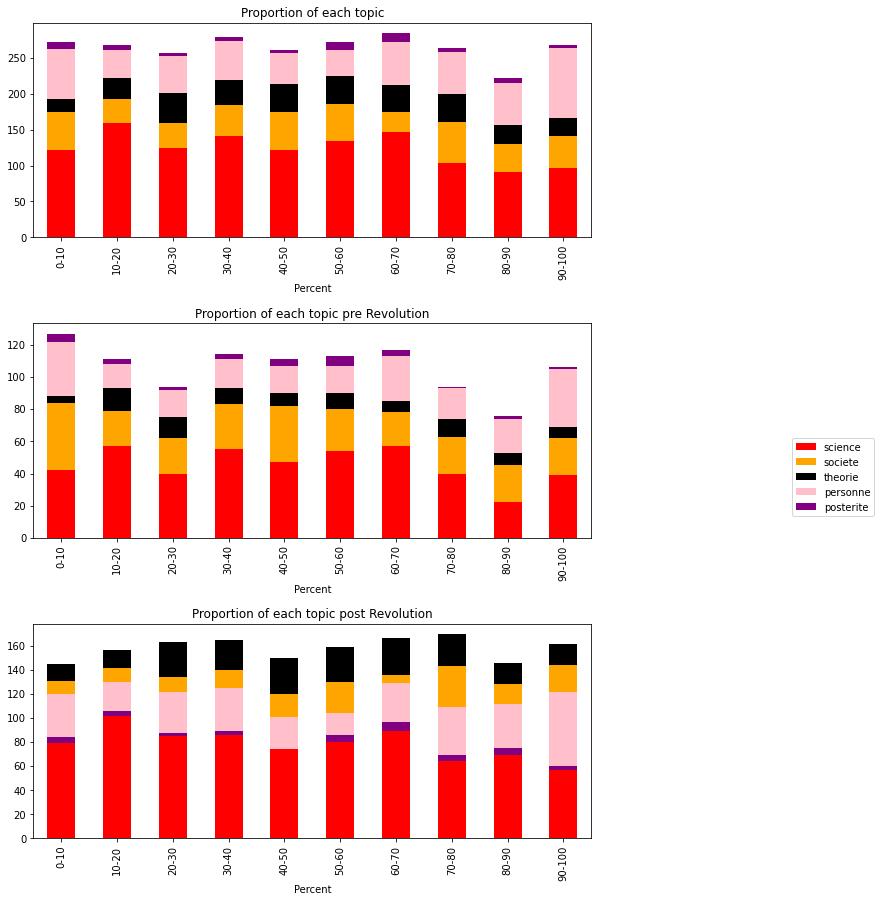

In [109]:
test,_,_ = plot_stack_bar(df_sent_hh)

144it [00:00, 22356.37it/s]
78it [00:00, 22216.20it/s]
66it [00:00, 20269.76it/s]


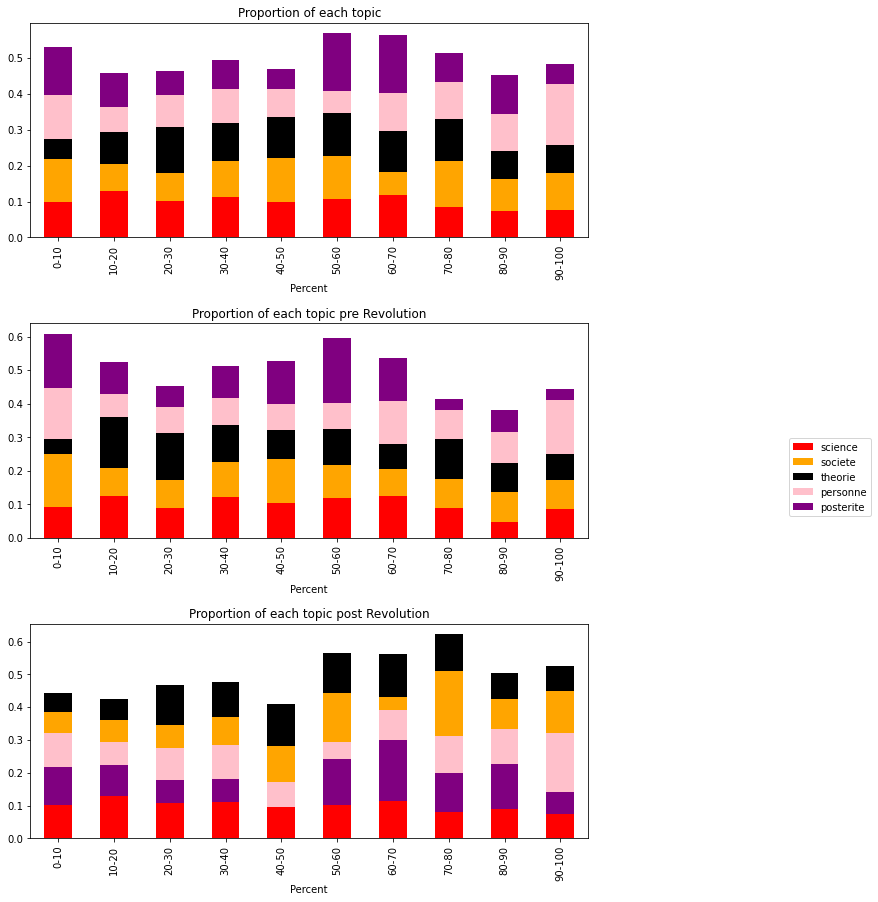

In [110]:
test,_,_ = plot_stack_bar(df_sent_hh, norm_by_tot=True)

No major differences

144it [00:00, 21144.79it/s]
78it [00:00, 18535.73it/s]
66it [00:00, 18008.33it/s]


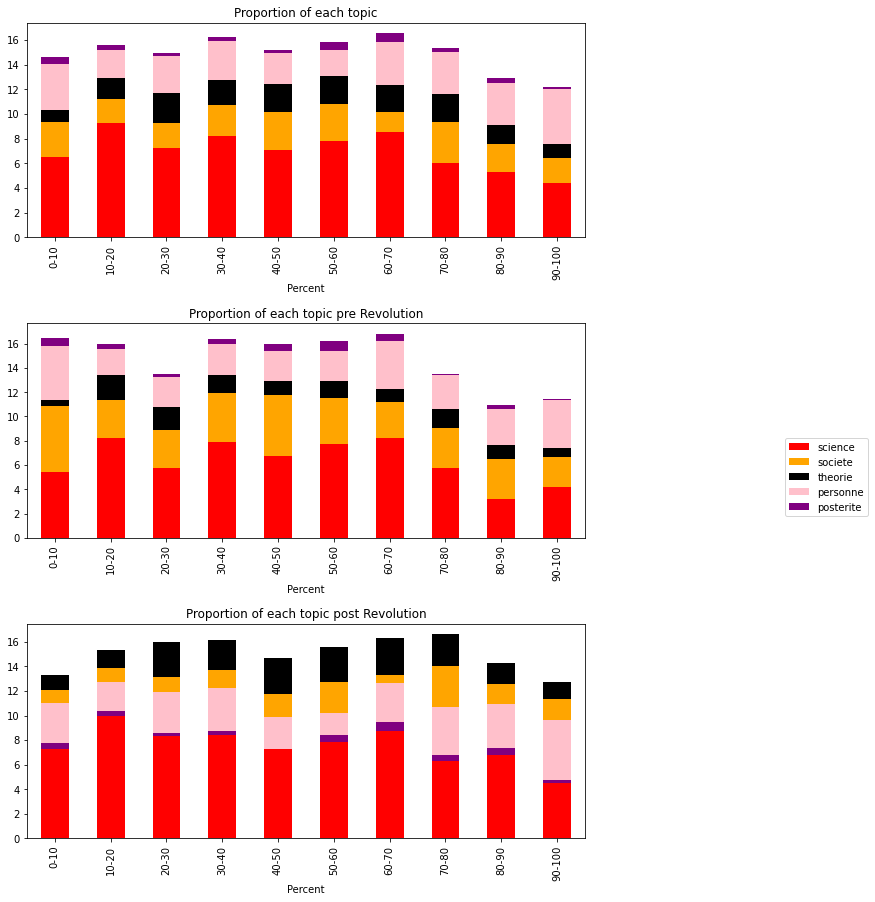

In [111]:
_,_,_ = plot_stack_bar(df_sent_hh, norm = True)

We speak more of politics before the Revolution, and more of travel after the Revolution

## By less higher topic

144it [00:00, 21596.93it/s]
78it [00:00, 20673.35it/s]
66it [00:00, 18303.63it/s]


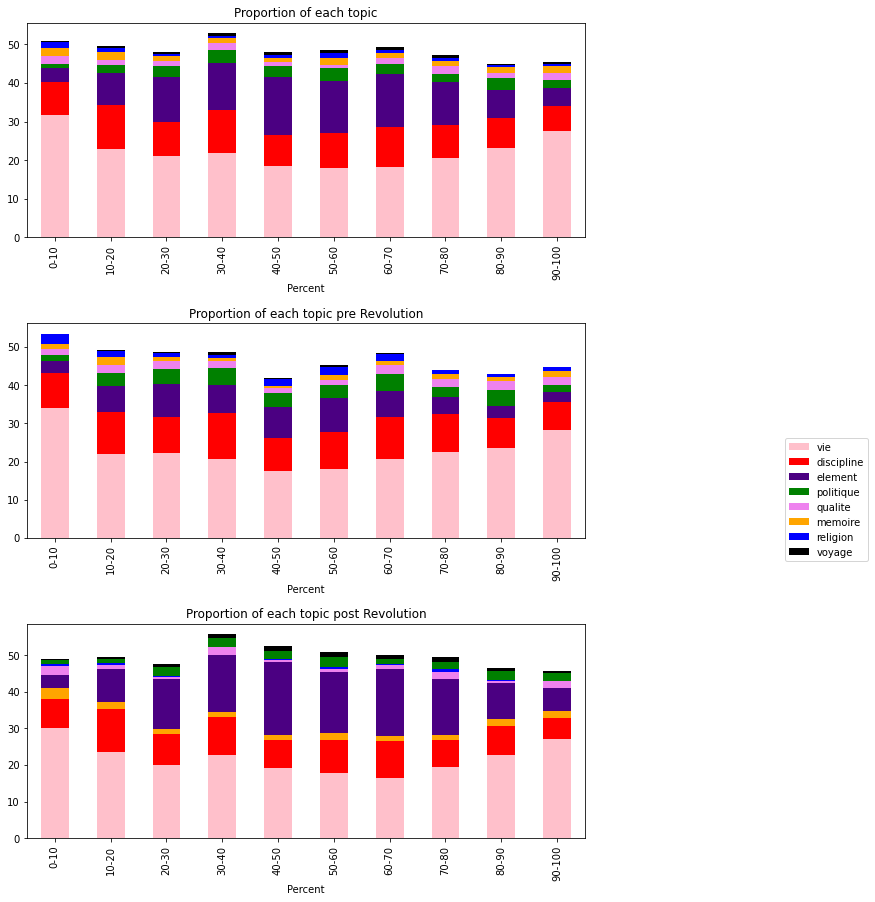

In [78]:
color_p = {'outlier' : 'grey', 'vie' : 'pink', 'qualite' : 'violet', 'discipline':
                                       'red', 'element' : 'indigo', 'memoire' : 'orange', 'politique' : 'green',
                                       'religion' : 'blue', 'voyage' : 'black'}
_,_,_=plot_stack_bar(df_sent_h, color_plot = color_p, norm = True, keep_outliers = False)

## Personne

In [79]:
df_vie = df_sent_t.copy()
df_vie['Topic_Ordered'] = df_vie['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_vie])

144it [00:00, 23534.12it/s]
78it [00:00, 22570.25it/s]
66it [00:00, 22231.29it/s]


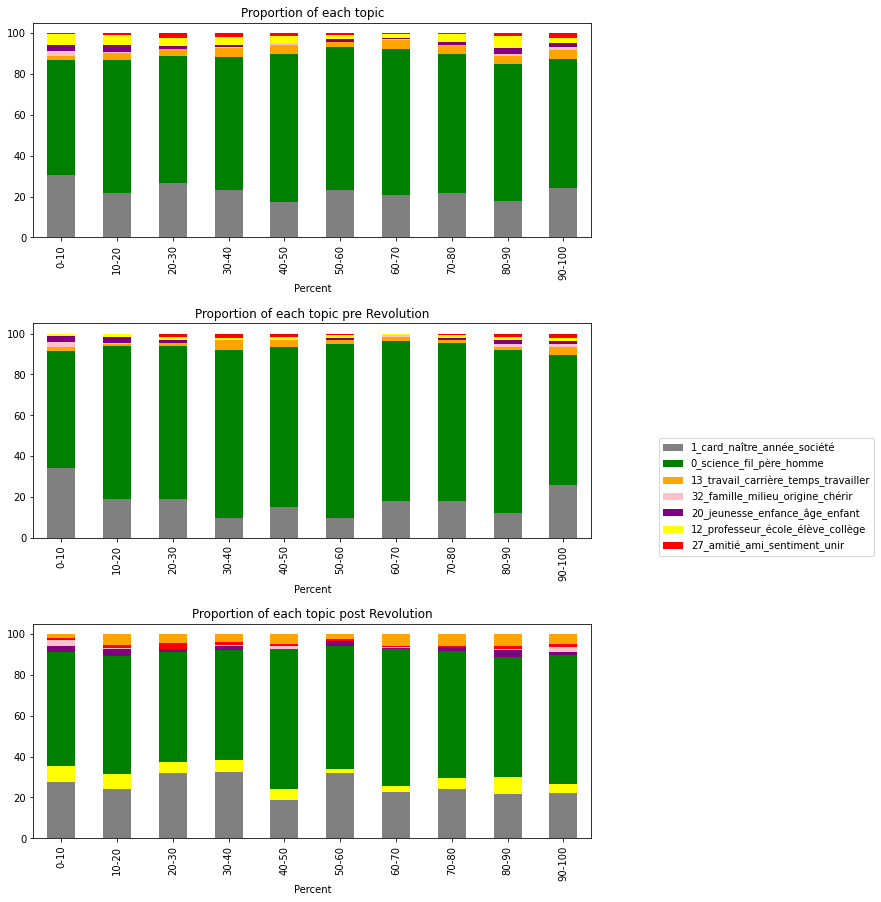

In [80]:
color_p = {'1_card_naître_année_société' : 'grey', '0_science_fil_père_homme' : 'green', '13_travail_carrière_temps_travailler' :
          'orange', '32_famille_milieu_origine_chérir' : 'pink', '20_jeunesse_enfance_âge_enfant' : 'purple',
          '12_professeur_école_élève_collège' : 'yellow', '27_amitié_ami_sentiment_unir' : 'red',
          '24_année_vie_travail_consacrer' : 'cyan', '41_été_ami_adresse_pallas' : 'indigo',
          '30_moi_mois_durer_passer' : 'black'}

_,_,_= plot_stack_bar(df_vie, keep_outliers = True, color_plot = color_p, norm = True)

On parle plus de la famille pre-revolution

## Jeunesse & mort

144it [00:00, 22270.64it/s]
78it [00:00, 19761.75it/s]
66it [00:00, 19298.94it/s]


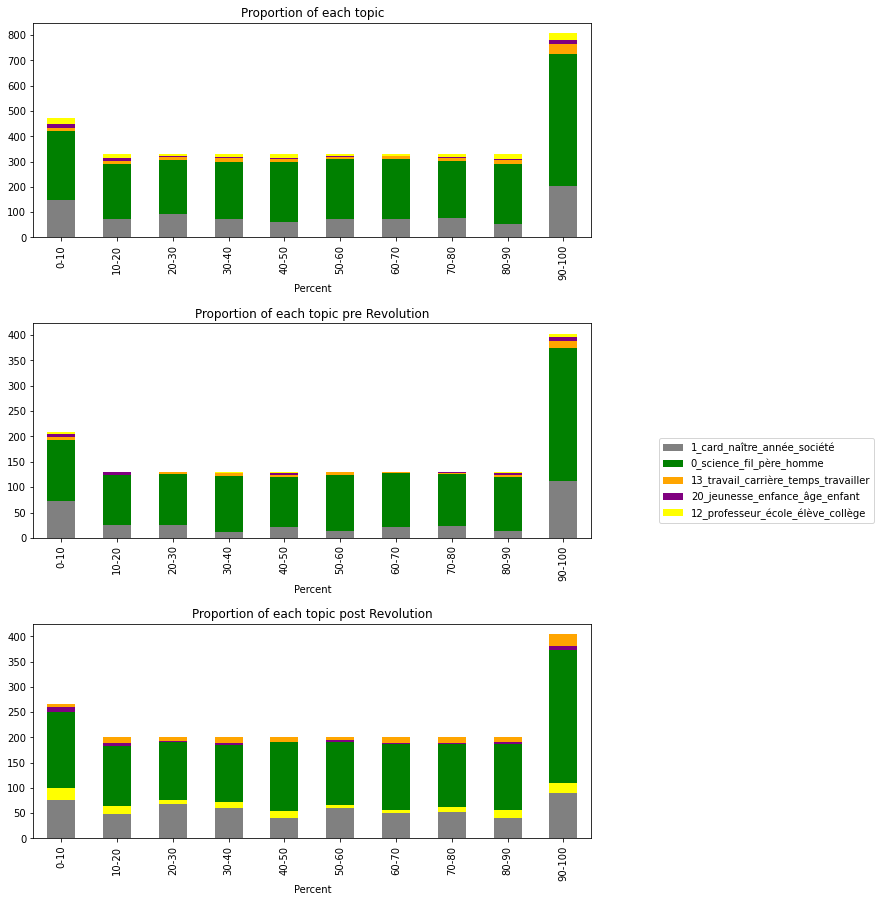

In [151]:
df_debut_fin = df_sent_t.copy()
df_debut_fin['Topic_Ordered'] = df_debut_fin['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in 
                                                                               [20, 13, 0, 1, 12]])
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm = False)

144it [00:00, 22228.84it/s]
78it [00:00, 20537.08it/s]
66it [00:00, 18808.54it/s]


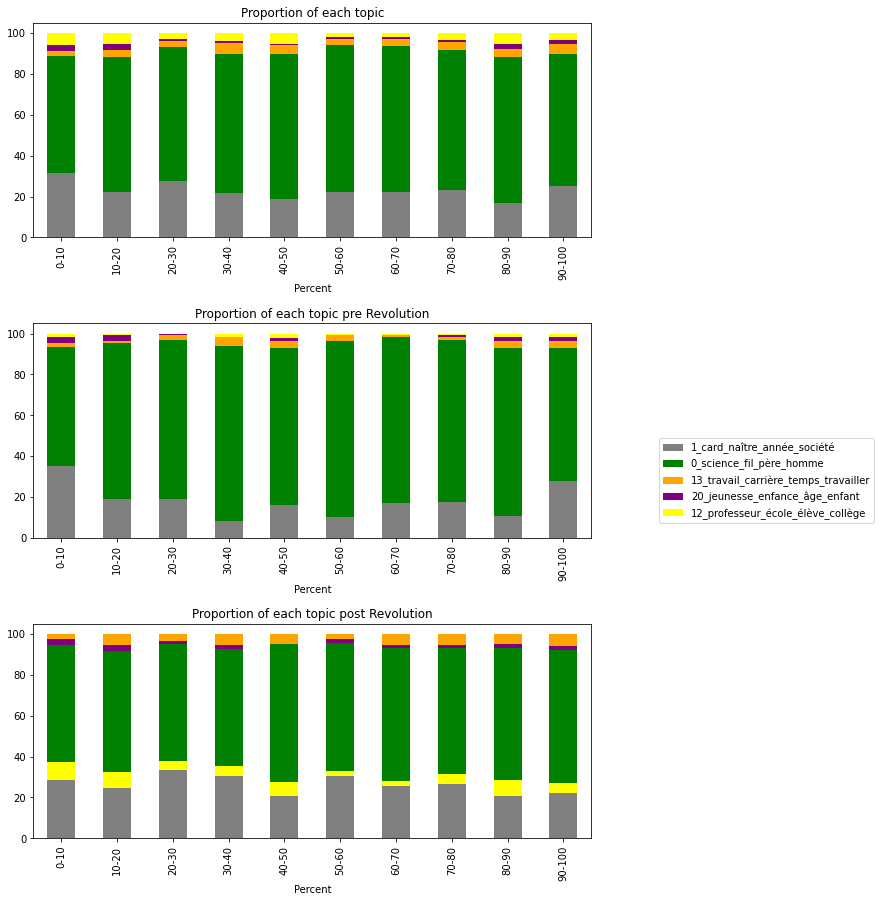

In [152]:
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm = True)

Professeur plus évoqué tout le long de la vie après révolution et la jeunesse aussi

144it [00:00, 23769.37it/s]
78it [00:00, 21658.77it/s]
66it [00:00, 20116.57it/s]


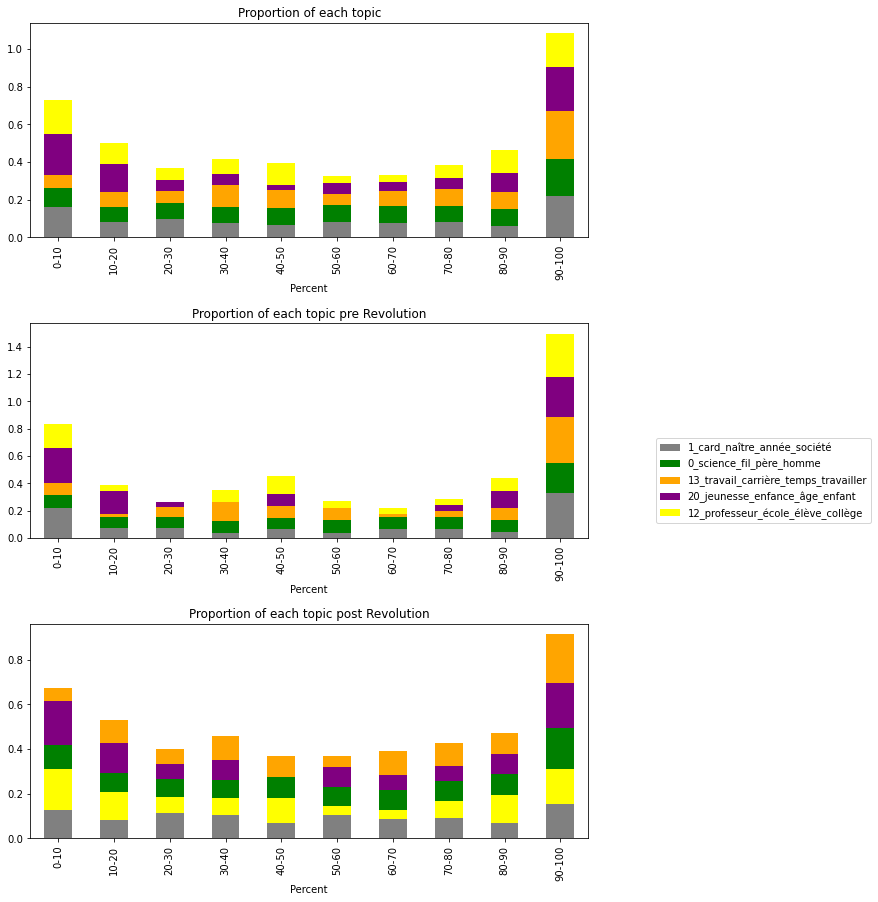

In [153]:
_,_,_=plot_stack_bar(df_debut_fin, color_plot = color_p, keep_outliers=True, norm_by_tot = True)

card, année publier mémoire évoqué tout le long de l'éloge après éa révolution tout comme progresseur et travail temps
Ce qui concerne la jeunesse semble plus réparti

## Relations

144it [00:00, 25763.76it/s]
78it [00:00, 22966.35it/s]
66it [00:00, 22149.47it/s]


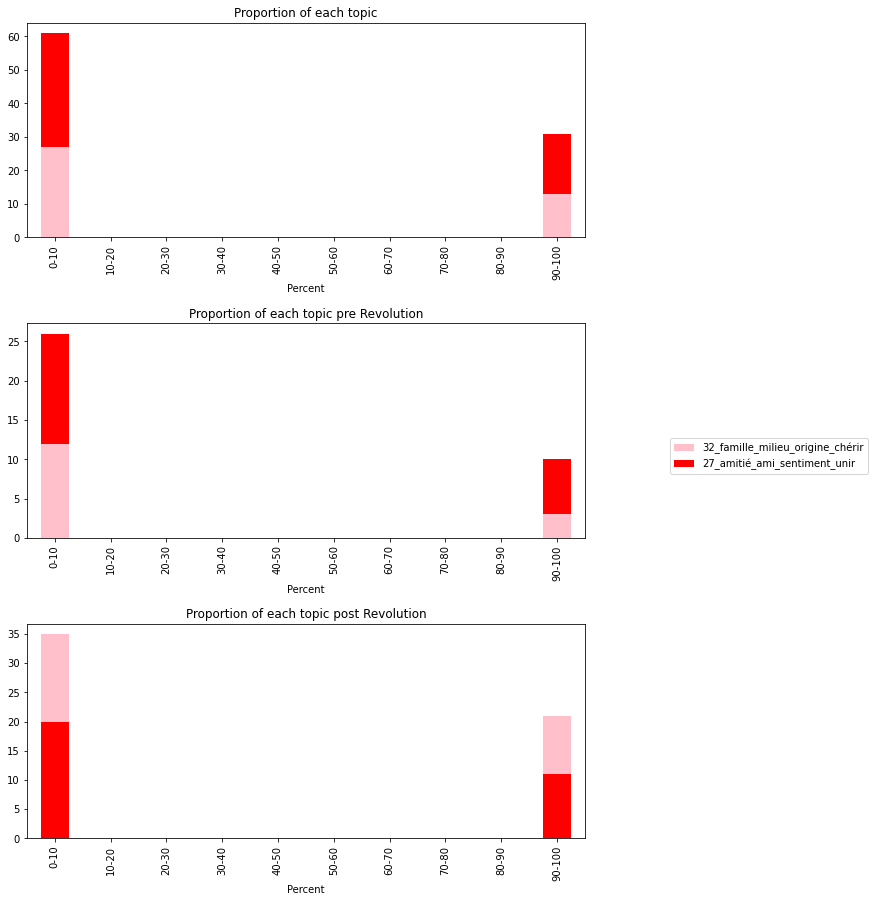

In [154]:
df_rel = df_sent_t.copy()
df_rel['Topic_Ordered'] = df_rel['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in [32,27]])

_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm = False)

144it [00:00, 26068.44it/s]
78it [00:00, 22601.43it/s]
66it [00:00, 22434.89it/s]


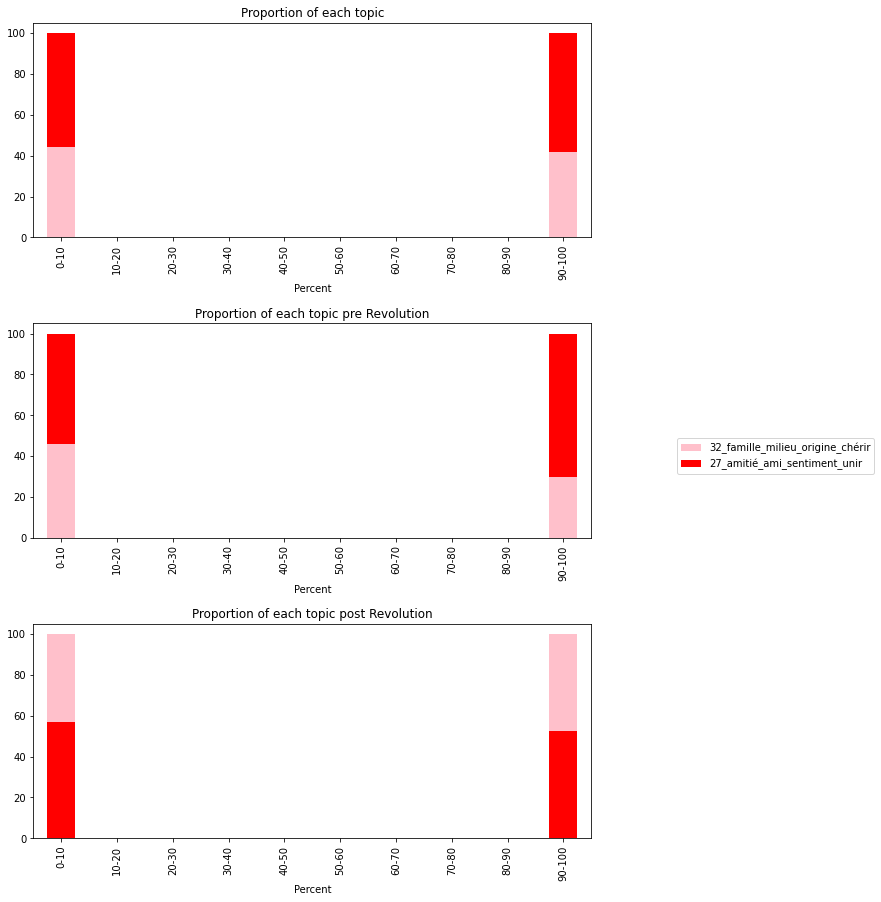

In [155]:

_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm = True)

Amis plus évoqués après la révolution dans l'éloge

144it [00:00, 25950.84it/s]
78it [00:00, 21577.35it/s]
66it [00:00, 22082.33it/s]


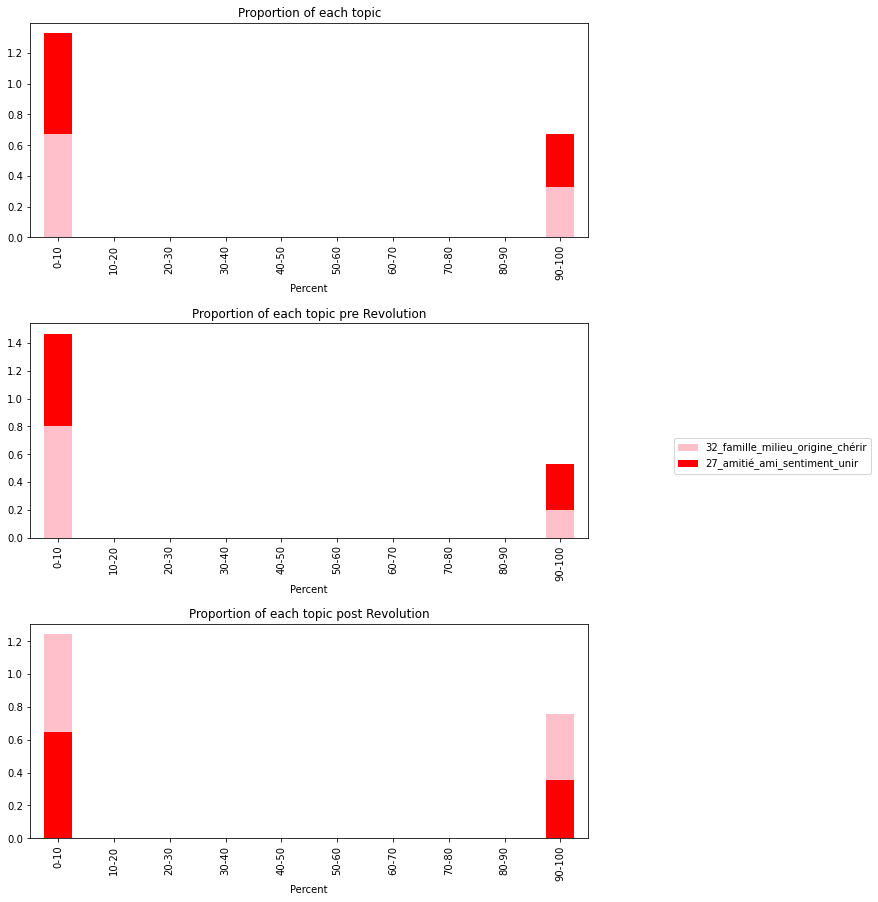

In [156]:
_,_,_=plot_stack_bar(df_rel, color_plot = color_p, keep_outliers=True, norm_by_tot = True)

Ami semble être à l'inverse de amour savoir

## Politique & Religion

In [157]:
df_pol = df_sent_t.copy()
df_pol['Topic_Ordered'] = df_pol['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_societe])

144it [00:00, 25424.30it/s]
78it [00:00, 22432.51it/s]
66it [00:00, 20207.61it/s]


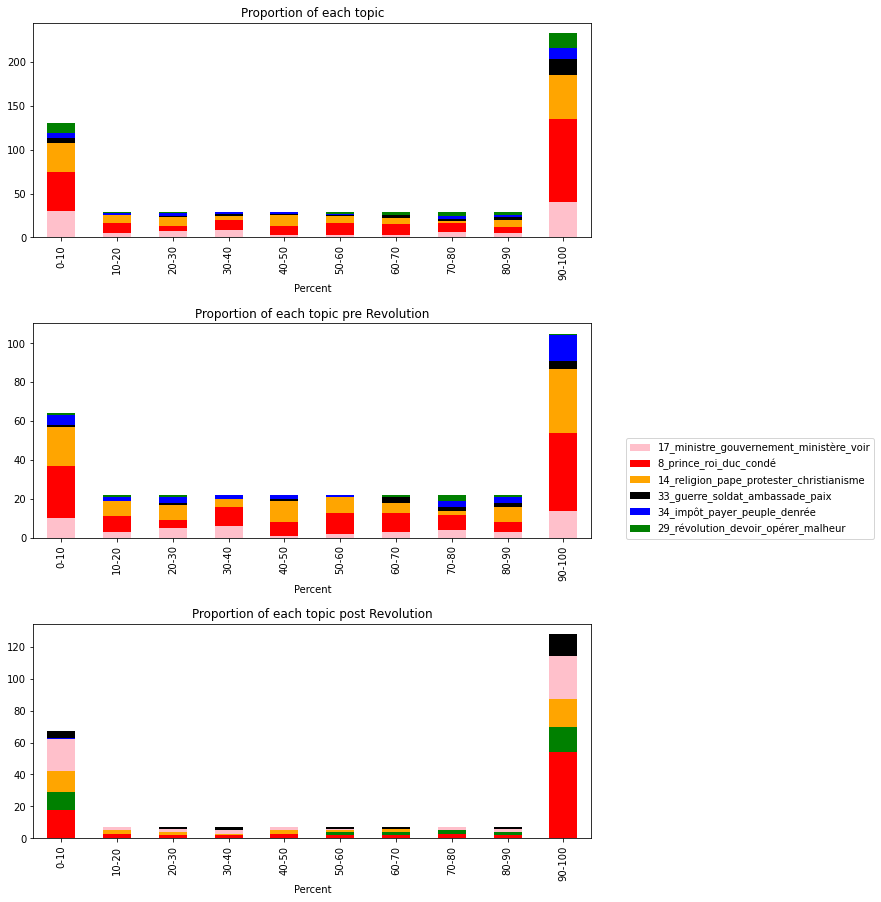

In [158]:
color_p = {'17_ministre_gouvernement_ministère_voir' : 'pink', '8_prince_roi_duc_condé' : 'red',
          '14_religion_pape_protester_christianisme' : 'orange', '33_guerre_soldat_ambassade_paix' : 'black',
          '34_impôt_payer_peuple_denrée' : 'blue', '29_révolution_devoir_opérer_malheur' : 'green',
          '39_impôt_payer_peuple_nation' : 'violet', '38_révolution_malheur_devoir_falloir' : 'cyan'}

_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = False)

Politique plus évoquée tout le long de l'éloge avant la révolution, particulièrement loi peuple nation pas hasard chancelier occuper perdre

144it [00:00, 25612.98it/s]
78it [00:00, 22634.27it/s]
66it [00:00, 21475.88it/s]


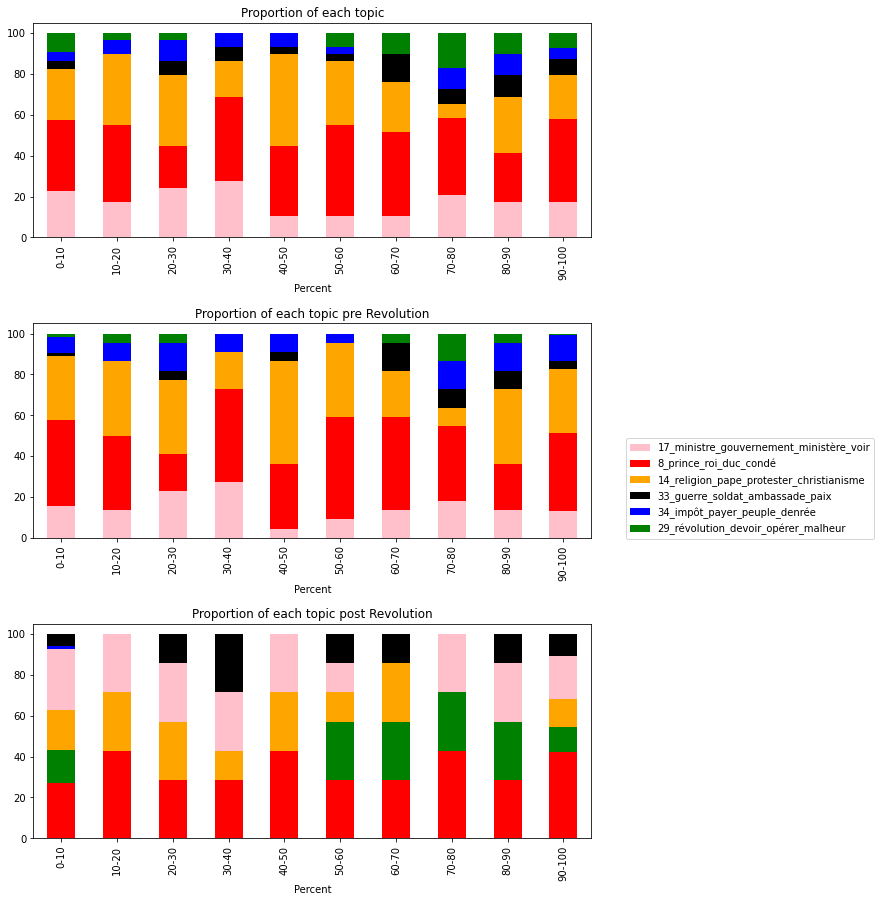

In [159]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm = True)

Les deux sujets les plus importants post rev sont hasard chancelier perdre occuper et ministre ainsi que roi

Plus réparti avant la révolution

Religion a une part plus improtante avant la révolution

144it [00:00, 25509.13it/s]
78it [00:00, 21798.75it/s]
66it [00:00, 20984.24it/s]


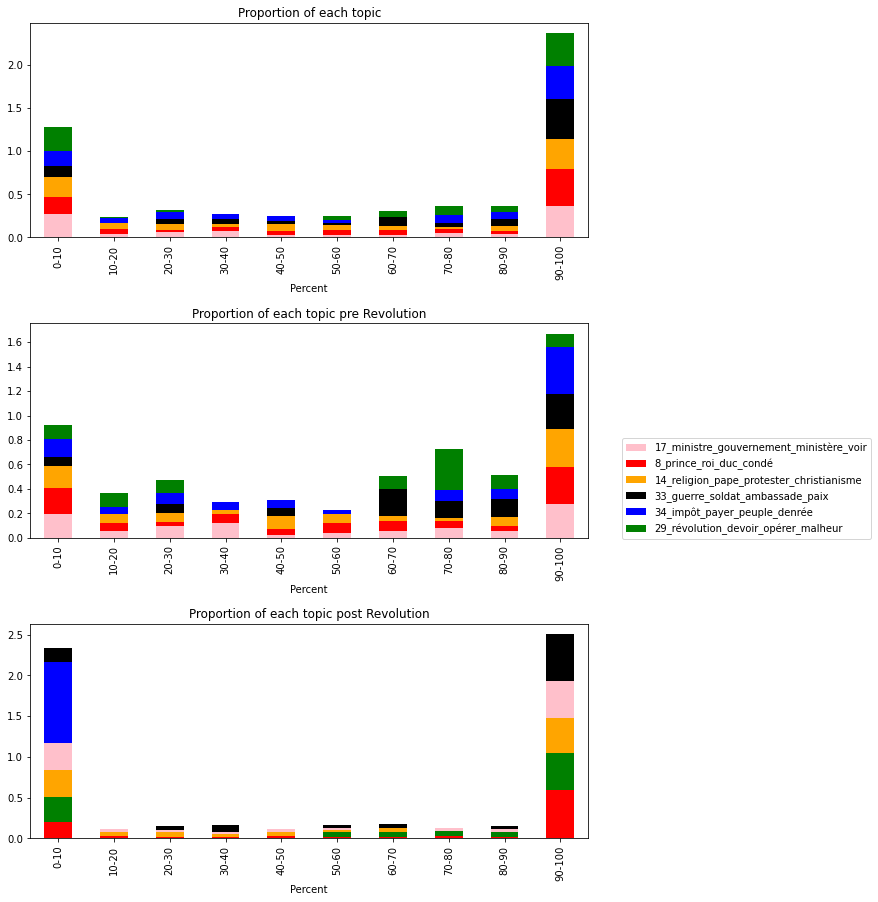

In [160]:
_, _, _ = plot_stack_bar(df_pol, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Posterite

In [161]:
df_pos = df_sent_t.copy()
df_pos['Topic_Ordered'] = df_pos['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_posterite])

144it [00:00, 25630.37it/s]
78it [00:00, 22908.46it/s]
66it [00:00, 22006.84it/s]


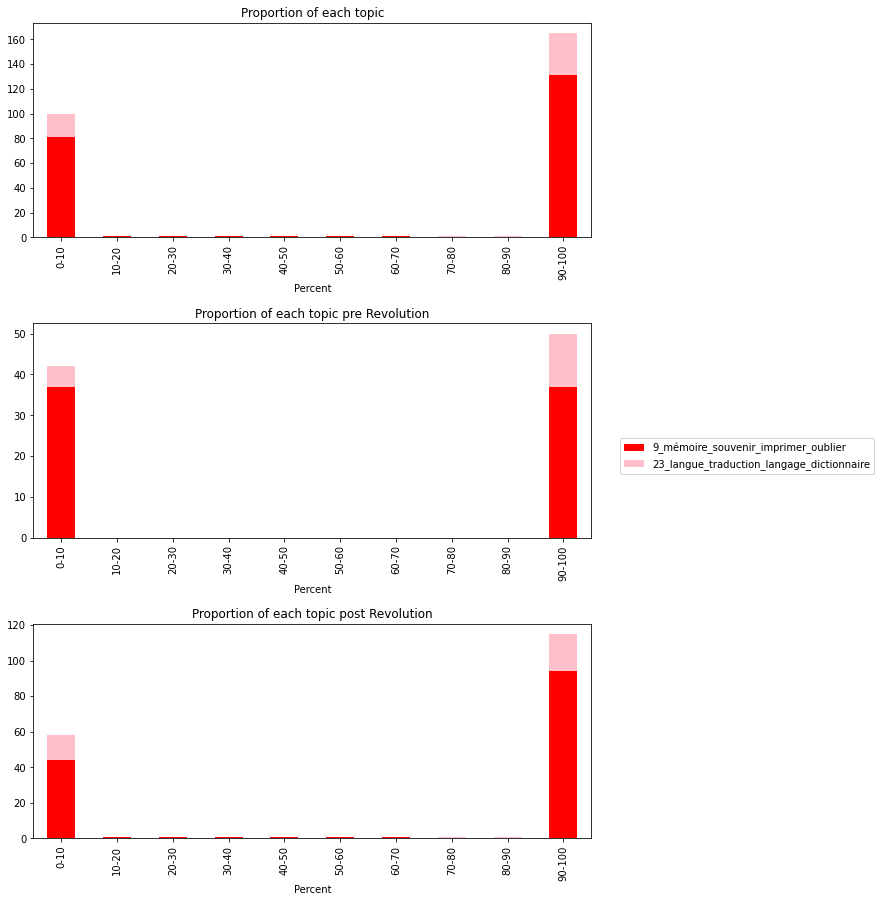

In [162]:
color_p = {'9_mémoire_souvenir_imprimer_oublier' : 'red', '23_langue_traduction_langage_dictionnaire' : 'pink',
         '27_histoire_auteur_ouvrage_livre' : 'orange'}

_,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p)

Postérité beaucoup plus présente dans l'éloge après la Révolution

144it [00:00, 25631.46it/s]
78it [00:00, 23353.25it/s]
66it [00:00, 21698.08it/s]


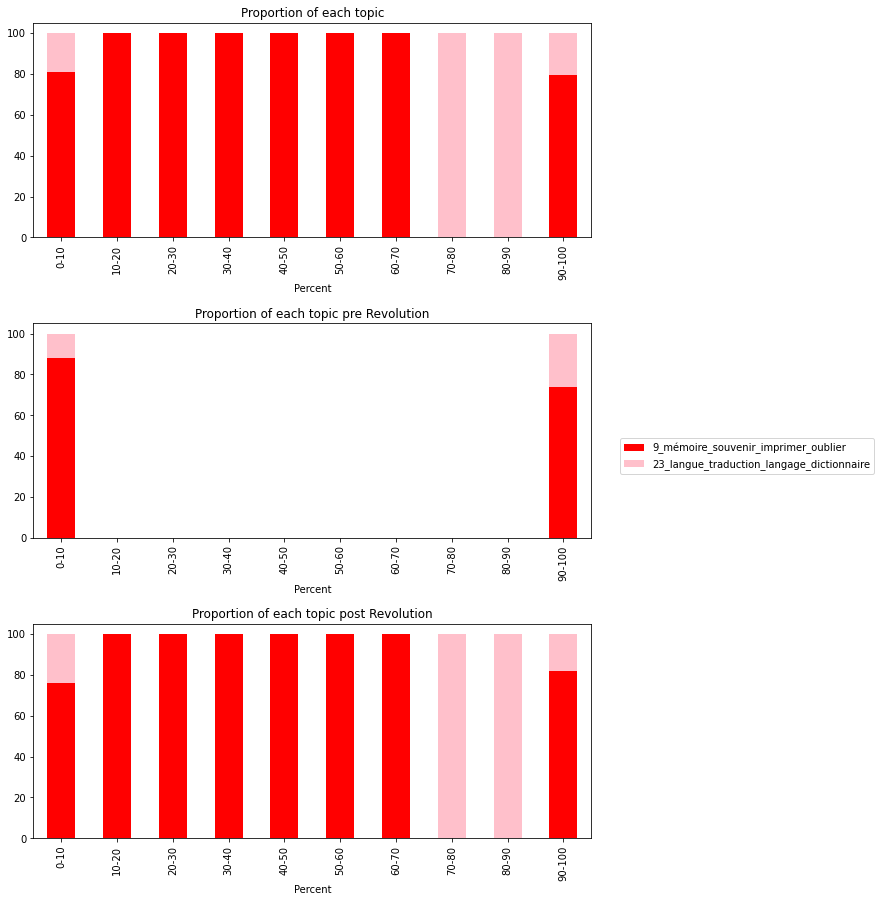

In [163]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm = True)

Avant la révolution postérité discutée qu'au début et à la fin de l'éloge par rapport à après la Révolution

144it [00:00, 23191.64it/s]
78it [00:00, 21952.34it/s]
66it [00:00, 21625.19it/s]


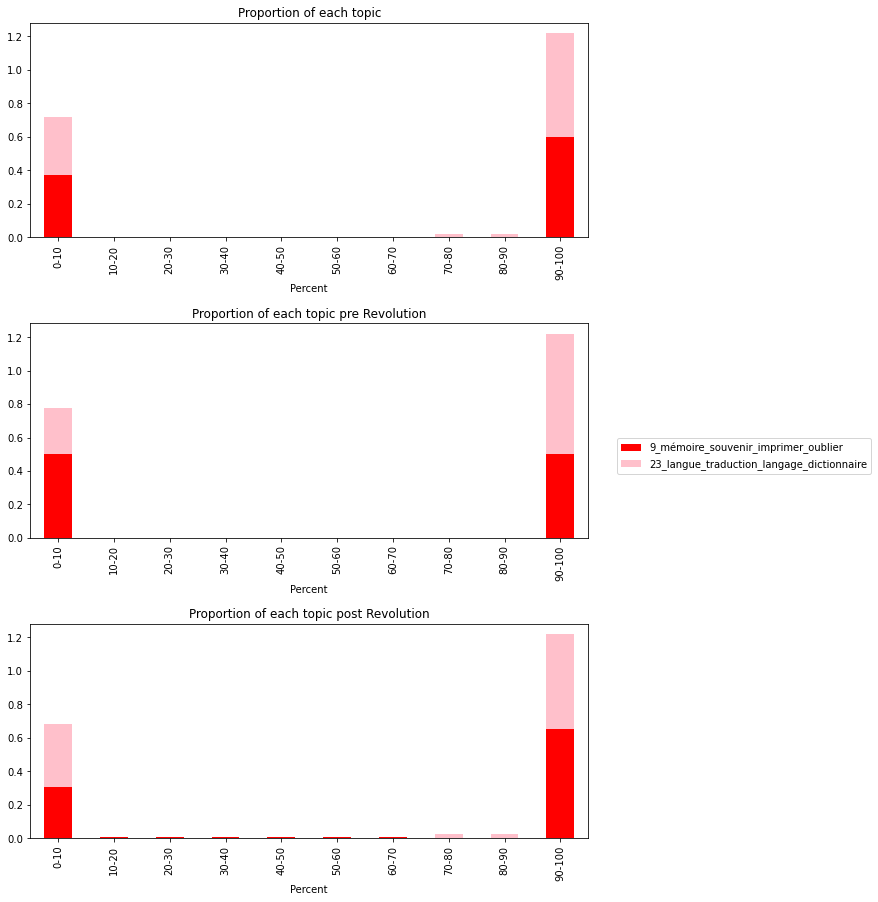

In [164]:
perc,_,_=plot_stack_bar(df_pos, keep_outliers = True, color_plot = color_p, norm_by_tot = True)

## Science

In [165]:
df_disc = df_sent_t.copy()
df_disc['Topic_Ordered'] = df_disc['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_discipline])

144it [00:00, 24169.83it/s]
78it [00:00, 22190.58it/s]
66it [00:00, 21059.27it/s]


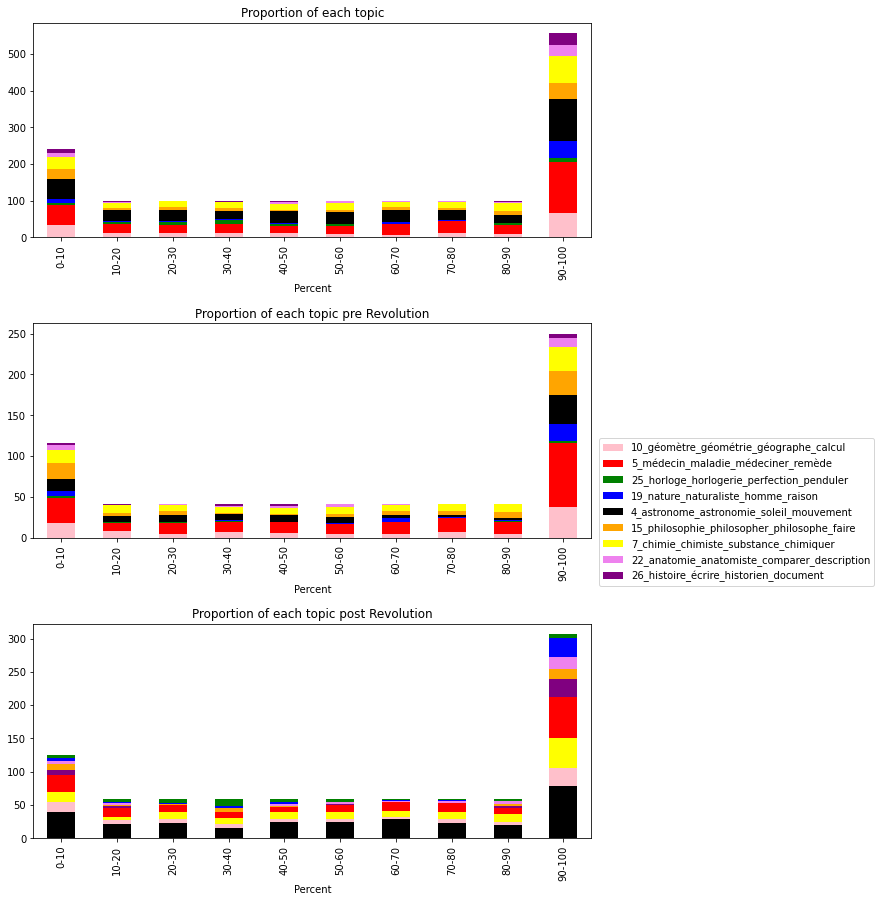

In [166]:
color_p = {'10_géomètre_géométrie_géographe_calcul'  : 'pink', '5_médecin_maladie_médeciner_remède' : 'red', 
          '25_horloge_horlogerie_perfection_penduler' : 'green', '19_nature_naturaliste_homme_raison' : 'blue',
          '4_astronome_astronomie_soleil_mouvement' : 'black', '15_philosophie_philosopher_philosophe_faire' :
          'orange', '22_anatomie_anatomiste_comparer_description' : 'violet', '6_pierre_montagne_rocher_volcan' :
          'grey', '7_chimie_chimiste_substance_chimiquer' : 'yellow', '26_histoire_écrire_historien_document' :
          'purple'}

#, '26_anatomie_anatomiste_histoire_comparer' : 'cyan', '13_pierre_montagne_rocher_volcan' :
#          'magenta', '18_rayon_lumière_rayer_raire' : 'brown', '27_esprit_âme_penser_idée' : 'beige',
 #         '23_expérience_confirmer_répéter_tenter' : 'gold', '2_planter_plante_espèce_jardin' : 'silver'
perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

144it [00:00, 24832.65it/s]
78it [00:00, 22471.03it/s]
66it [00:00, 20799.76it/s]


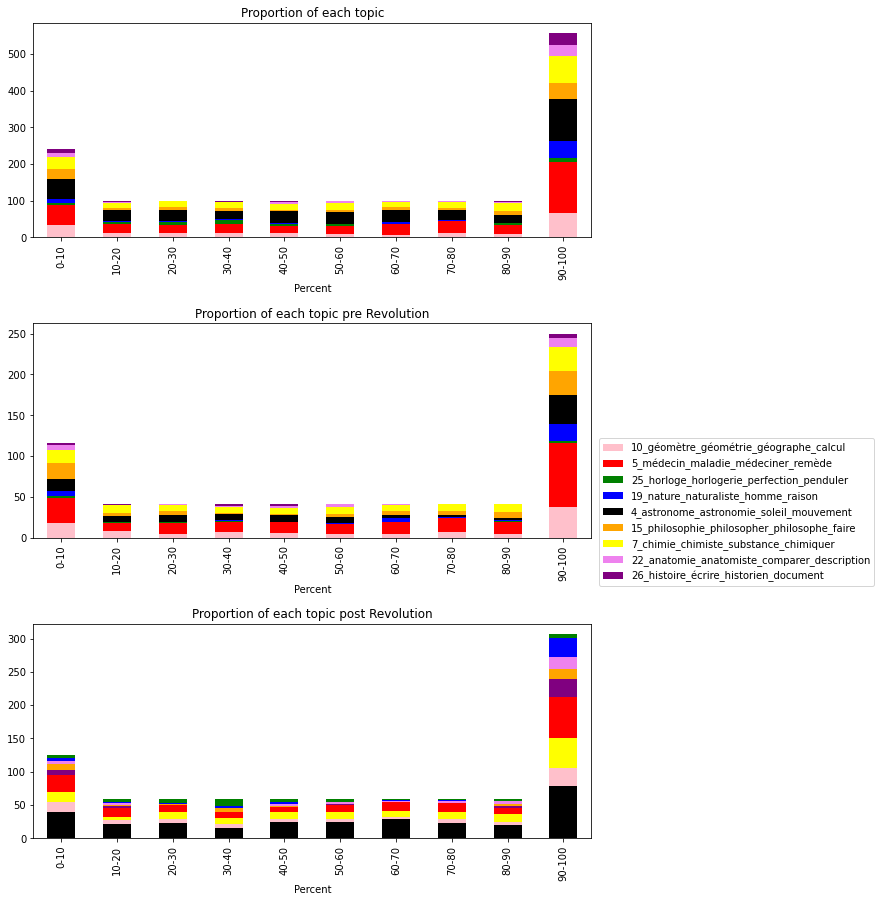

In [167]:
perc,_,_ = plot_stack_bar(df_disc, keep_outliers = True, color_plot = color_p)

On parle plus de science dans le milieu du texte

On parle plus de l'art du dessin et de la peinture et philo en proportion

## Element

In [168]:
df_elem = df_sent_t.copy()
df_elem['Topic_Ordered'] = df_elem['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_element])

144it [00:00, 24939.29it/s]
78it [00:00, 22722.30it/s]
66it [00:00, 19666.39it/s]


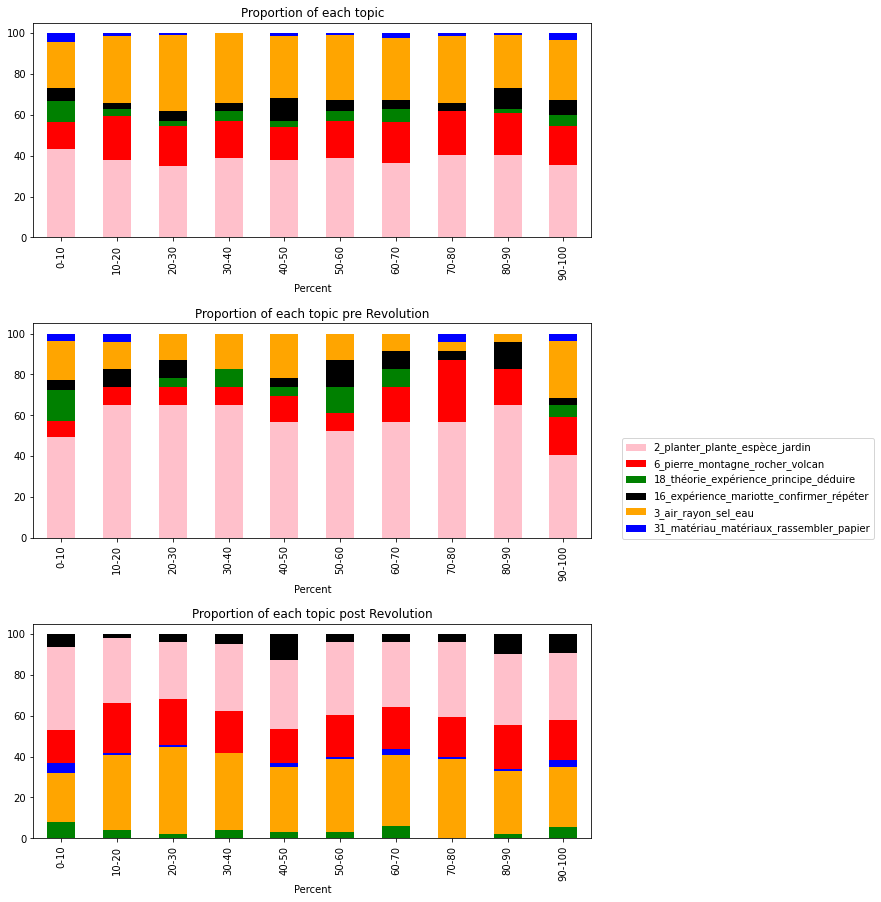

In [169]:
color_p = {'2_planter_plante_espèce_jardin'  : 'pink', '6_pierre_montagne_rocher_volcan' : 'red', 
          '18_théorie_expérience_principe_déduire' : 'green', '31_matériau_matériaux_rassembler_papier' : 'blue',
          '16_expérience_mariotte_confirmer_répéter' : 'black', '3_air_rayon_sel_eau' :
          'orange', '36_mouvement_vitesse_poids_oscillation' : 'violet', '1_planter_plante_espèce_jardin' :
          'grey', '47_comparer_comparaison_table_observation': 'yellow', '7_air_sel_gaz_alcali' :
          'purple', '44_matériau_matériaux_rassembler_papier' :
          'cyan', '18_rayon_lumière_rayer_raire' : 'brown'}#, '27_esprit_âme_penser_idée' : 'beige'}

perc,_,_ = plot_stack_bar(df_elem, keep_outliers = True, color_plot = color_p, norm = True)

144it [00:00, 24823.47it/s]
78it [00:00, 22471.03it/s]
66it [00:00, 19982.97it/s]


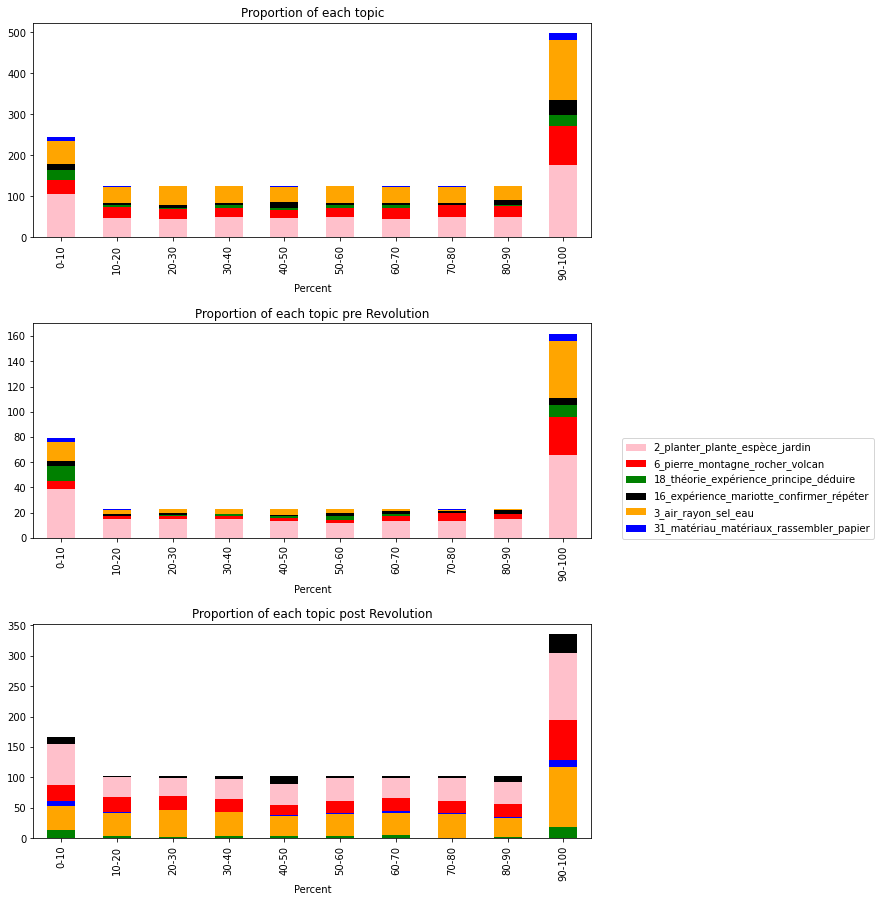

In [170]:
perc,_,_ = plot_stack_bar(df_elem, keep_outliers = True, color_plot = color_p)

## Voyage

144it [00:00, 25829.87it/s]
78it [00:00, 23125.45it/s]
66it [00:00, 21883.33it/s]


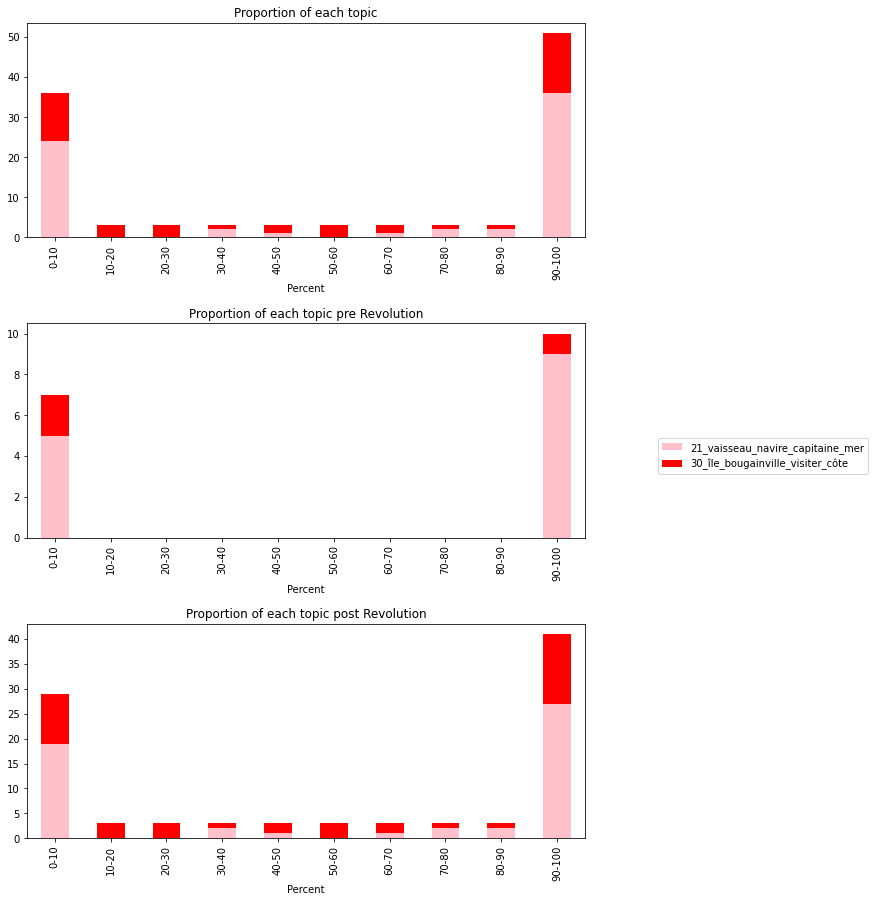

In [171]:
df_voy = df_sent_t.copy()
df_voy['Topic_Ordered'] = df_voy['Topic_Ordered'].apply(lambda x :[tup for tup in x if tup[0] in topic_voyage])

color_p = {'21_vaisseau_navire_capitaine_mer'  : 'pink', '30_île_bougainville_visiter_côte' : 'red'}

perc,_,_ = plot_stack_bar(df_voy, keep_outliers = True, color_plot = color_p, norm = False)

# Assertivité

In [59]:
df_ass = pd.read_csv('./../../Data/Results/ADV_BIG.csv')


In [60]:
df_ass.fillna('default value', inplace =True)

In [61]:
df_ass[(df_ass['Assertivité']=='default value') & (df_ass['Temporalité']=='default value') &
      (df_ass['Expérience']=='default value')][['Adverb', 'Assertivité']]

Adverb    Assertivité
0    -ci             default value
1    -ci ne          default value
3    ailleurs        default value
4    ainsi           default value
6    alors           default value
..     ...                     ...
406  volontairement  default value
407  volontiers      default value
411  également       default value
412  éminemment      default value
414  étroitement     default value

[233 rows x 2 columns]

In [62]:
df_ass[(df_ass['Assertivité']=='default value') & (df_ass['Temporalité']=='default value') &
      (df_ass['Expérience']=='default value')][['Adverb', 'Assertivité']].shape

(233, 2)

In [63]:
df_ass[df_ass['Assertivité']!='default value'][['Adverb', 'Assertivité']]

Adverb Assertivité
2    absolument          certain   
9    alors presque       presque   
10   alors seulement     certain   
14   apparemment         presque   
18   assurément          certain   
57   certainement        certain   
61   clairement          certain   
69   communément         presque   
70   complètement        tout      
118  entièrement         tout      
119  environ             presque   
120  essentiellement     presque   
122  exactement          certain   
136  guères              presque   
137  généralement        presque   
148  incontestablement   certain   
156  inévitablement      certain   
159  jamais              certain   
162  justement           certain   
191  naturellement       certain   
208  nullement           certain   
219  partout             certain   
250  peut-être           moitié    
251  peut-être aussi     moitié    
252  peut-être encore    moitié    
253  peut-être même      moitié    
254  peut-être ne        moitié    
255  peut-être pas       moitié    
256  peut-être plus      moitié    
257  peut-être trop      moitié    
258  pleinement          tout      
264  plus exactement     presque   
273  plus souvent        presque   
274  plus sûrement       presque   
278  plutôt              presque   
289  presque absolument  presque   
301  principalement      presque   
302  probablement        presque   
303  probablement pas    peu       
317  quelquefois         peu       
352  souvent             presque   
361  surtout             certain   
362  surtout plus        certain   
365  sûrement            presque   
372  totalement          tout      
373  toujours            certain   
377  tout                tout      
408  vraiment            presque   
409  vraisemblablement   presque   
410  véritablement       certain   
415  évidemment          certain

In [64]:
df_ass[df_ass['Temporalité']!='default value'][['Adverb', 'Temporalité']]

Adverb Temporalité
12   anciennement        passe     
13   annuellement        fréquence 
15   après               suite     
17   assez longtemps     presque   
22   aujourd'hui         maintenant
23   auparavant          passe     
27   aussi longtemps     passe     
30   aussitôt            tot       
34   autrefois           passe     
52   bientôt             presque   
53   bientôt après       suite     
73   constamment         maintenant
74   continuellement     eternel   
80   depuis              suite     
95   définitivement      eternel   
96   déjà                maintenant
100  désormais           maintenant
103  encore aujourd'hui  maintenant
107  encore longtemps    presque   
117  ensuite             suite     
124  expressément        tot       
132  graduellement       fréquence 
143  immédiatement       maintenant
146  incessamment        tot       
149  indéfiniment        eternel   
151  infiniment          eternel   
156  inévitablement      eternel   
158  jadis               passe     
159  jamais              eternel   
160  jamais rien         eternel   
161  journellement       fréquence 
163  lentement           tard      
166  longtemps           presque   
171  maintenant          maintenant
182  momentanément       tot       
190  même quelquefois    peu       
193  ne jamais           eternel   
207  nouvellement        tot       
217  parfois             peu       
231  pas longtemps       peu       
238  pas toujours        presque   
243  personne encore     maintenant
261  plus anciennement   passe     
267  plus longtemps      presque   
270  plus promptement    tot       
273  plus souvent        presque   
275  plus tard           suite     
276  plus tôt            tot       
291  presque aussitôt    tot       
294  presque jamais      presque   
296  presque pas         presque   
298  presque toujours    presque   
305  promptement         tot       
310  puis                suite     
317  quelquefois         peu       
318  quelquefois même    peu       
319  rapidement          tot       
320  rarement            peu       
326  récemment           passe     
338  si longtemps        presque   
342  si rarement         peu       
343  si souvent          presque   
344  si vite             tot       
349  sitôt               tot       
352  souvent             presque   
357  subitement          tot       
358  successivement      suite     
367  tantôt              suite     
369  tard                tard      
373  toujours            eternel   
374  toujours plus       eternel   
375  toujours si         eternel   
376  toujours très       eternel   
395  tôt                 tot       
402  vite                tot       
413  éternellement       eternel

In [65]:
df_ass[df_ass['Expérience']!='default value'][['Adverb', 'Expérience']]

Adverb Expérience
5    aisément              plus     
37   avidement             moins    
40   beaucoup mieux        plus     
44   bien                  plus     
54   bon                   plus     
71   conformément          plus     
75   convenablement        plus     
77   cruellement           moins    
82   difficilement         moins    
84   dignement             plus     
93   doucement             plus     
108  encore mieux          plus     
129  fidèlement            plus     
130  fort                  plus     
138  généreusement         plus     
140  heureusement          plus     
144  imprudemment          moins    
145  impunément            moins    
148  incontestablement     plus     
153  insensiblement        moins    
154  inutilement           moins    
155  inégalement           moins    
162  justement             plus     
172  mal                   moins    
173  malheureusement       moins    
174  malheureusement trop  moins    
175  mieux                 plus     
176  mieux encore          plus     
177  modestement           plus     
200  noblement             plus     
215  paisiblement          plus     
216  parfaitement          plus     
223  pas assez             moins    
226  pas bien              moins    
260  plus aisément         plus     
265  plus fortement        plus     
277  plus vivement         plus     
281  point assez           moins    
284  positivement          plus     
306  proprement            plus     
311  puissamment           plus     
312  purement              plus     
313  péniblement           moins    
325  rigoureusement        plus     
330  sagement              plus     
331  scrupuleusement       plus     
335  si aisément           plus     
336  si bien               plus     
347  sincèrement           plus     
350  soigneusement         plus     
351  solennellement        plus     
359  suffisamment          plus     
364  sérieusement          plus     
371  tendrement            plus     
385  trop facilement       moins    
386  trop loin             moins    
387  trop longtemps        moins    
388  trop peu              moins    
389  trop souvent          moins    
390  trop tard             moins    
391  trop tôt              moins    
393  très bien             plus     
398  utilement             plus     
399  vainement             moins

In [66]:
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait 

In [67]:
adv = keep_adv(sent, 'Eloge')

In [68]:
df_ass['Temp_Ass'] = df_ass.apply(lambda row : 1 if ((row['Assertivité']!='default value') & 
                                  (row['Temporalité']!='default value')) else 0,axis=1)
df_ass['Temp_Exp'] = df_ass.apply(lambda row : 1 if ((row['Expérience']!='default value') & 
                                  (row['Temporalité']!='default value')) else 0,axis=1)
df_ass['Ass_Exp'] = df_ass.apply(lambda row : 1 if ((row['Assertivité']!='default value') & 
                                 (row['Expérience']!='default value')) else 0,axis=1)


In [69]:
df_ass.head()

Adverb  Number_x      Categorie    Assertivité    Temporalité  \
0  -ci         74        default value  default value  default value   
1  -ci ne      5         default value  default value  default value   
2  absolument  54        affirmation    certain        default value   
3  ailleurs    91        lieu           default value  default value   
4  ainsi       564       logique        default value  default value   

      Expérience    Description  Temp_Ass  Temp_Exp  Ass_Exp  
0  default value  description    0         0         0        
1  default value  description    0         0         0        
2  default value  default value  0         0         0        
3  default value  default value  0         0         0        
4  default value  default value  0         0         0

In [89]:
ls_ass = df_ass[(df_ass['Assertivité']!='default value') & (df_ass['Temp_Ass']==0) &
                                                         (df_ass['Ass_Exp']==0)]['Adverb'].tolist()
ls_temp = df_ass[(df_ass['Temporalité']!='default value') & (df_ass['Temp_Ass']==0)
                & (df_ass['Temp_Exp']==0)]['Adverb'].tolist()
ls_exp = df_ass[(df_ass['Expérience']!='default value') & (df_ass['Temp_Exp']==0)
               & (df_ass['Ass_Exp']==0)]['Adverb'].tolist()
ls_temp_exp = df_ass[df_ass['Temp_Exp']==1]['Adverb'].tolist()
ls_ass_exp = df_ass[df_ass['Ass_Exp']==1]['Adverb'].tolist()
ls_temp_ass = df_ass[df_ass['Temp_Ass']==1]['Adverb'].tolist()
ls_desc = df_ass[df_ass['Description']=='description']['Adverb'].tolist()

In [91]:
plot_adv = adv.copy()
plot_adv = plot_adv[['Savant', 'Auteur', 'Annee', 'Eloge', 'adverbs']]
plot_adv['Assertivité'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass]))
plot_adv['Temporalité'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp]))
plot_adv['Expérience'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_exp]))
plot_adv['Temp_Ass'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp_ass]))
plot_adv['Temp_Exp'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_temp_exp]))
plot_adv['Ass_Exp'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_ass_exp]))
plot_adv['Description'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if elem in ls_desc]))
plot_adv['Else'] = plot_adv['adverbs'].apply(lambda x : len([elem for elem in x if (elem not in ls_ass
                                                                                   and elem not in ls_temp
                                                                                   and elem not in ls_exp
                                                                                   and elem not in ls_ass
                                                                                   and elem not in ls_temp_ass
                                                                                   and elem not in ls_ass_exp
                                                                                   and elem not in ls_temp_exp
                                                                                   and elem not in ls_desc)]))

In [92]:
plot_adv_1 = plot_adv.groupby(['Annee']).agg({'Assertivité' : 'sum', 'Temporalité' : 'sum', 'Expérience' :
                                           'sum', 'Temp_Ass' : 'sum', 'Ass_Exp' : 'sum', 'Temp_Exp' : 'sum',
                                           'Description' : 'sum', 'Else' : 'sum'})

<AxesSubplot:xlabel='Annee'>

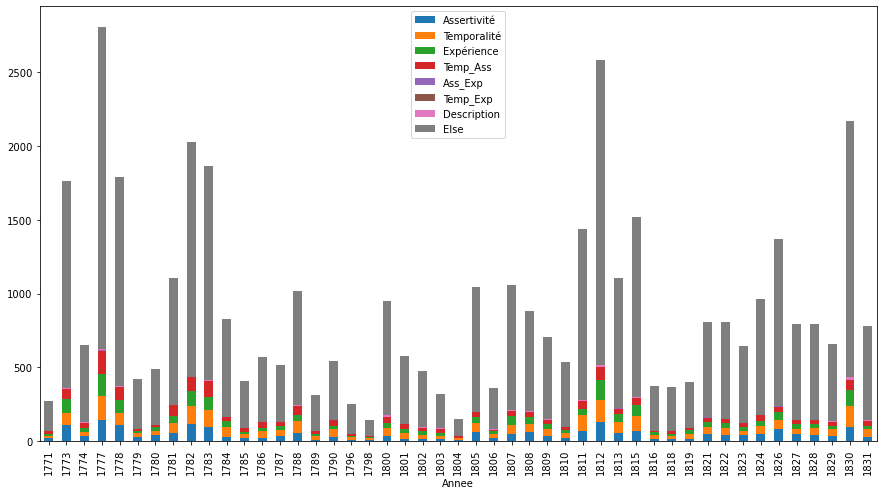

In [93]:
plot_adv_1.plot.bar(stacked = True, figsize = (15,8))

In [95]:
plot_adv['Catégorie'] = plot_adv['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()
                                                             ['Categorie'][0]  
                                                             if elem in df_ass.Adverb.tolist() else 'Not Frequent'
                                                             for elem in x])

plot_adv.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait 

In [96]:
new_df = (
    plot_adv.explode('Catégorie')  # Explode List into Rows
        .groupby(['Annee','Catégorie']).size()  # Calculate Group Sizes
        .unstack(fill_value=0)  # Convert Category values to column names 
        .reset_index().rename_axis(columns=None)  # Cleanup
)

In [97]:
new_df.set_index('Annee', inplace = True)

<AxesSubplot:xlabel='Annee'>

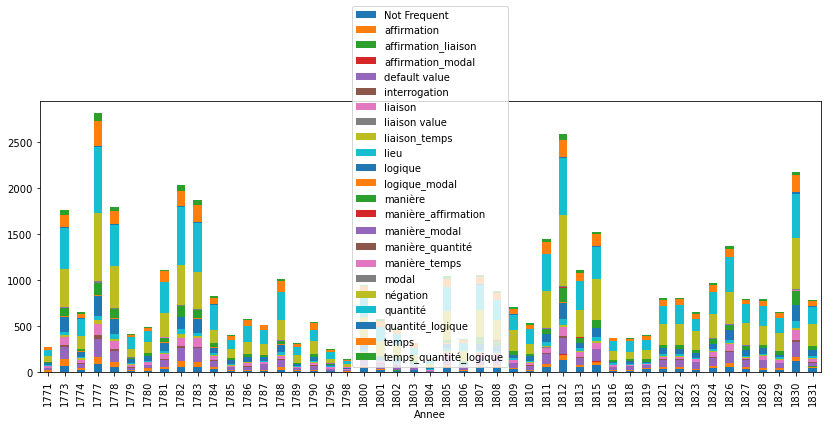

In [98]:
new_df.plot.bar( stacked=True, figsize = (14,5))

<AxesSubplot:xlabel='Annee'>

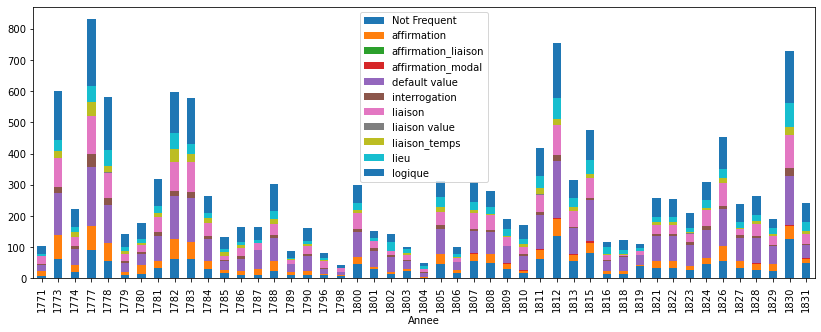

In [99]:
new_df.iloc[:,:11].plot.bar( stacked=True, figsize = (14,5))

<AxesSubplot:xlabel='Annee'>

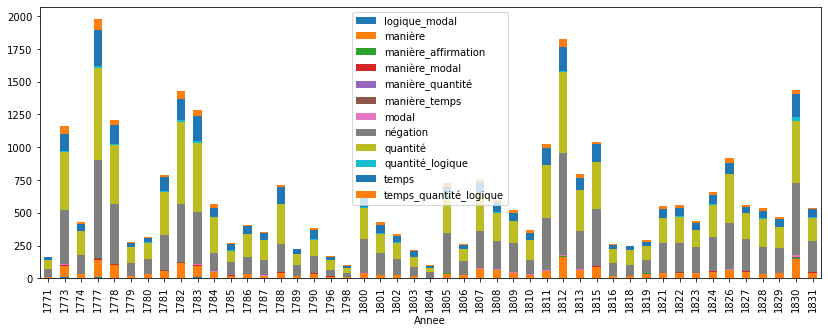

In [100]:
new_df.iloc[:,11:].plot.bar( stacked=True, figsize = (14,5))

In [101]:
plot_adv

Savant     Auteur  Annee  \
0      Fontaine   Condorcet  1771    
1      Fontaine   Condorcet  1771    
2      Fontaine   Condorcet  1771    
3      Fontaine   Condorcet  1771    
4      Fontaine   Condorcet  1771    
...         ...         ...   ...    
17762  Desmarets  Cuvier     1815    
17763  Desmarets  Cuvier     1815    
17764  Desmarets  Cuvier     1815    
17765  Desmarets  Cuvier     1815    
17766  Desmarets  Cuvier     1815    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           Eloge  \
0      Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1       Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2       Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3       Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que d

In [102]:
plot_adv_1['All'] = plot_adv_1.sum(axis=1)
plot_adv_1['Assertivité'] = plot_adv_1.apply(lambda row : row['Assertivité']/row['All'],axis=1)
plot_adv_1['Temporalité'] = plot_adv_1.apply(lambda row : row['Temporalité']/row['All'],axis=1)
plot_adv_1['Expérience'] = plot_adv_1.apply(lambda row : row['Expérience']/row['All'],axis=1)
plot_adv_1['Temp_Ass'] = plot_adv_1.apply(lambda row : row['Temp_Ass']/row['All'],axis=1)
plot_adv_1['Temp_Exp'] = plot_adv_1.apply(lambda row : row['Temp_Exp']/row['All'],axis=1)
plot_adv_1['Ass_Exp'] = plot_adv_1.apply(lambda row : row['Ass_Exp']/row['All'],axis=1)

<AxesSubplot:xlabel='Annee'>

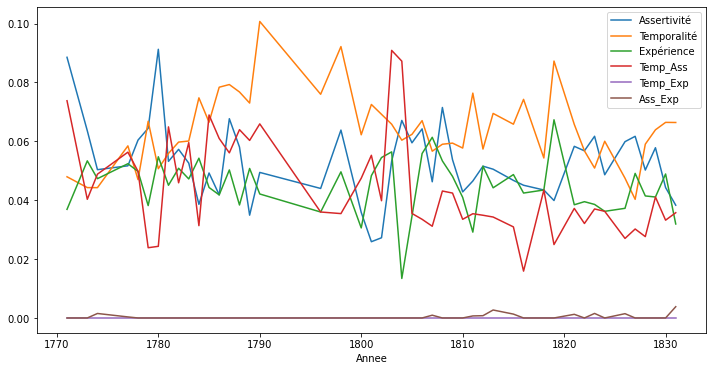

In [103]:
plot_adv_1[['Assertivité', 'Temporalité', 'Expérience', 'Temp_Ass', 'Temp_Exp', 'Ass_Exp']].plot(kind='line',
                                                                                              figsize = (12,6))

In [104]:
plot_adv_1.tail()

Assertivité  Temporalité  Expérience  Temp_Ass   Ass_Exp  Temp_Exp  \
Annee                                                                       
1827   0.061713     0.040302     0.049118    0.030227  0.000000  0.0        
1828   0.050251     0.059045     0.041457    0.027638  0.000000  0.0        
1829   0.057839     0.063927     0.041096    0.041096  0.000000  0.0        
1830   0.044301     0.066451     0.048916    0.033226  0.000000  0.0        
1831   0.038314     0.066411     0.031928    0.035760  0.003831  0.0        

       Description  Else   All  
Annee                           
1827   2            648   794   
1828   2            652   796   
1829   4            519   657   
1830   20           1729  2167  
1831   8            637   783

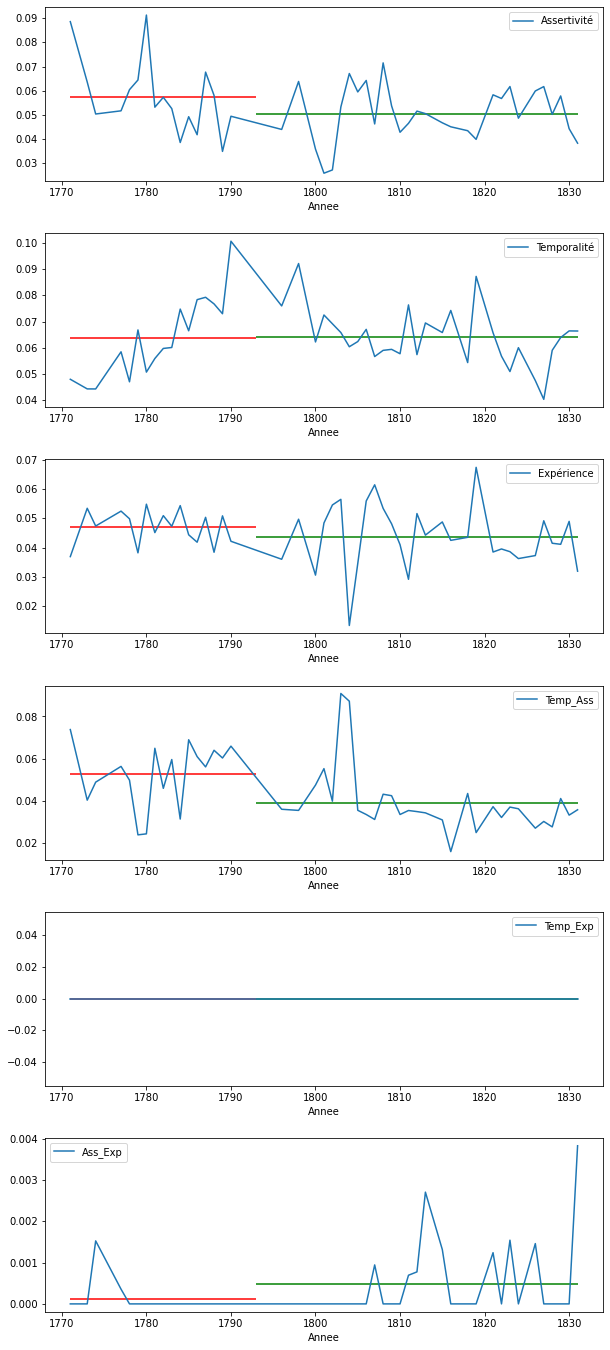

In [105]:
fig, ax = plt.subplots(nrows = 6, ncols=1, figsize = (10, 6*4))

ls = ['Assertivité', 'Temporalité', 'Expérience', 'Temp_Ass', 'Temp_Exp', 'Ass_Exp']
for idx, cat in enumerate(ls):
    y1 = plot_adv_1[plot_adv_1.index<=1793][cat].mean()
    y2 = plot_adv_1[plot_adv_1.index>1793][cat].mean()
    plot_adv_1[[cat]].plot(kind='line', ax = ax[idx])
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-')
        
plt.legend()
plt.subplots_adjust(hspace = 0.3)


## Assertivity

In [106]:
ass = adv.copy()
ass = ass[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
ass['adverbs'] = ass['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_ass or elem in ls_temp_ass
                                                                        or elem in ls_ass_exp)])

ass['Catégorie'] = ass['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Assertivité'][0]
                                                   for elem in x])

In [107]:
ass.head()

Auteur  Annee    Savant  \
0  Condorcet  1771   Fontaine   
1  Condorcet  1771   Fontaine   
2  Condorcet  1771   Fontaine   
3  Condorcet  1771   Fontaine   
4  Condorcet  1771   Fontaine   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait a

In [112]:
ls_cat = ass['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['moitié', 'certain', 'presque', 'tout', 'peu'], dtype=object)

In [113]:
for cat in ls_cat :
    ass[cat] = ass['Catégorie'].apply(lambda x : x.count(cat))
    
ass_plot = ass.groupby(['Annee'])[ls_cat].sum()

<AxesSubplot:xlabel='Annee'>

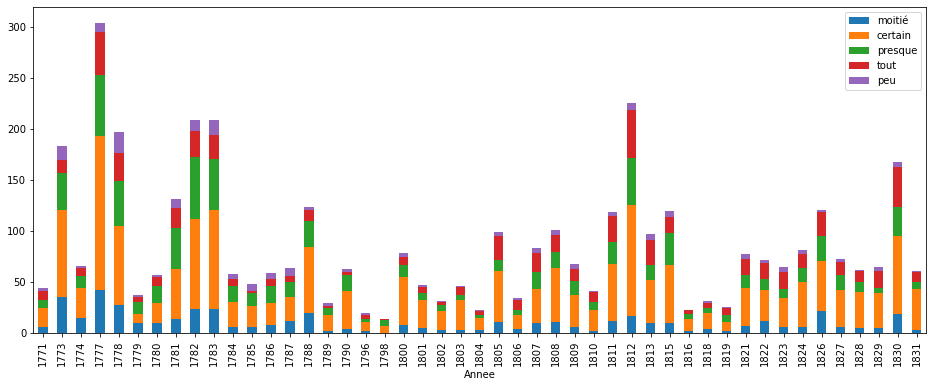

In [114]:
ass_plot.plot(kind='bar', stacked=True, figsize = (16,6))

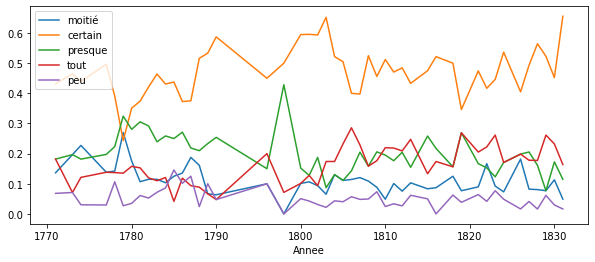

In [115]:
ass_plot['all'] = ass_plot.sum(axis=1)

for cat in ls_cat:
    ass_plot[cat] = ass_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    ass_plot[cat].plot(kind='line', figsize = (10,4), label=cat)
    
plt.legend()

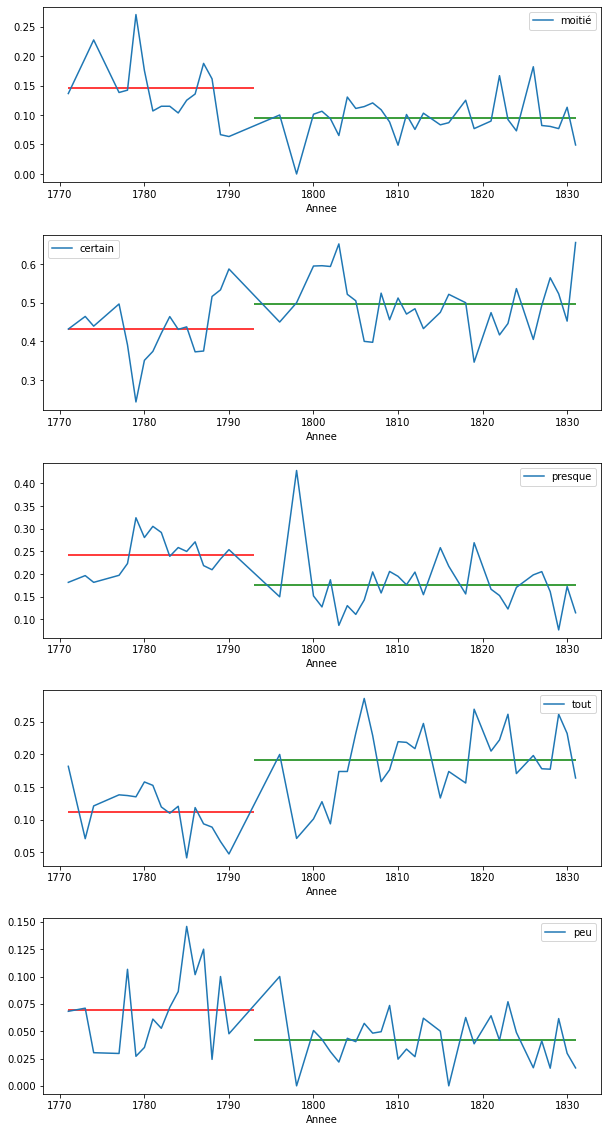

In [116]:
fig, ax = plt.subplots(nrows = ls_cat.size, ncols=1, figsize = (10, ls_cat.size*4))

for idx, cat in enumerate(ls_cat):
    y1 = ass_plot[ass_plot.index<=1793][cat].mean()
    y2 = ass_plot[ass_plot.index>1793][cat].mean()
    ass_plot[[cat]].plot(kind='line', ax = ax[idx])
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-')
        
plt.legend()
plt.subplots_adjust(hspace = 0.3)

## Temporality

In [117]:
temp = adv.copy()
temp = temp[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
temp['adverbs'] = temp['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_temp or elem in ls_temp_ass
                                                                        or elem in ls_temp_exp)])

temp['Catégorie'] = temp['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Temporalité'][0]
                                                   for elem in x])

In [118]:
ls_cat = temp['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['peu', 'presque', 'suite', 'maintenant', 'eternel', 'tot', 'passe',
       'tard', 'fréquence'], dtype=object)

In [119]:
for cat in ls_cat :
    temp[cat] = temp['Catégorie'].apply(lambda x : x.count(cat))
    
temp_plot = temp.groupby(['Annee'])[ls_cat].sum()

<AxesSubplot:xlabel='Annee'>

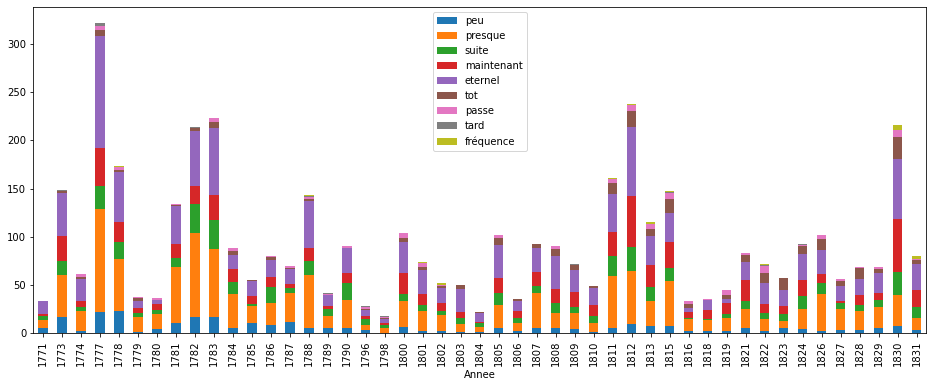

In [120]:
temp_plot.plot(kind='bar', stacked=True, figsize = (16,6))

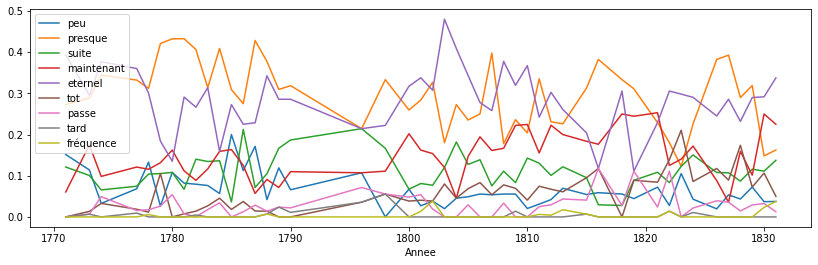

In [121]:
temp_plot['all'] = temp_plot.sum(axis=1)

for cat in ls_cat:
    temp_plot[cat] = temp_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    temp_plot[cat].plot(kind='line', figsize = (14,4), label=cat)
    
plt.legend()

In [122]:
df_ass[df_ass['Temporalité']=='maintenant']

Adverb  Number_x      Categorie    Assertivité Temporalité  \
22   aujourd'hui         138       temps          default value  maintenant   
73   constamment         64        manière        default value  maintenant   
96   déjà                331       temps          default value  maintenant   
100  désormais           30        liaison        default value  maintenant   
103  encore aujourd'hui  15        default value  default value  maintenant   
143  immédiatement       33        temps          default value  maintenant   
171  maintenant          50        temps          default value  maintenant   
243  personne encore     7         default value  default value  maintenant   

        Expérience    Description  Temp_Ass  Temp_Exp  Ass_Exp  
22   default value  default value  0         0         0        
73   default value  default value  0         0         0        
96   default value  default value  0         0         0        
100  default value  default value  0         0         0        
103  default value  default value  0         0         0        
143  default value  default value  0         0         0        
171  default value  default value  0         0         0        
243  default value  default value  0         0         0

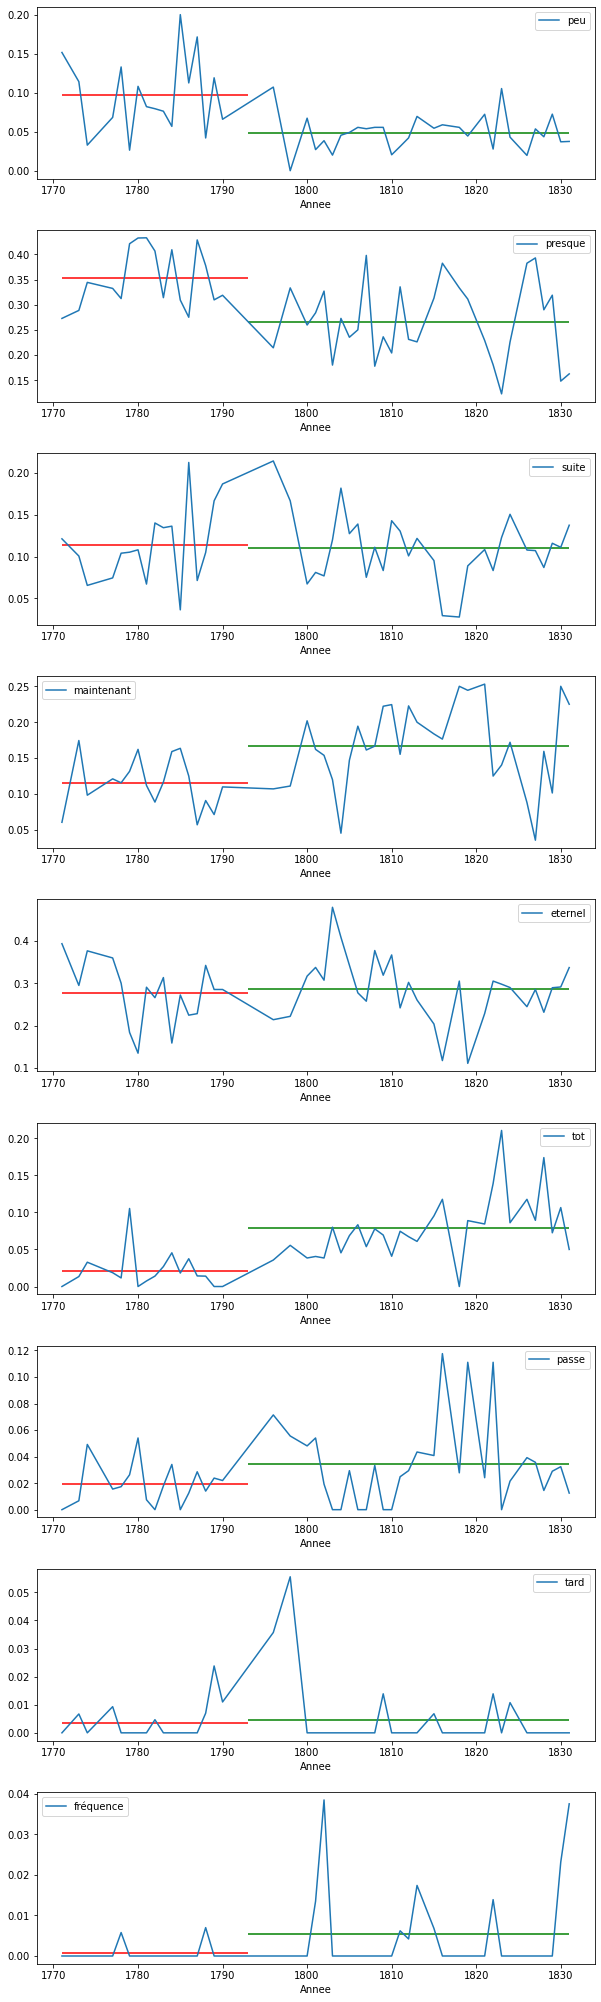

In [123]:
fig, ax = plt.subplots(nrows = ls_cat.size, ncols=1, figsize = (10, ls_cat.size*4))

for idx, cat in enumerate(ls_cat):
    y1 = temp_plot[temp_plot.index<=1793][cat].mean()
    y2 = temp_plot[temp_plot.index>1793][cat].mean()
    temp_plot[[cat]].plot(kind='line', ax = ax[idx])
    ax[idx].hlines(y=y1, xmin=1771,xmax=1793, color='r', linestyle='-')
    ax[idx].hlines(y=y2,xmin=1793, xmax=1831, color='g', linestyle='-')
        
plt.legend()
plt.subplots_adjust(hspace = 0.3)

## Experience

In [124]:
exp = adv.copy()
exp = exp[['Auteur', 'Annee', 'Savant', 'Eloge', 'adverbs']]
exp['adverbs'] = exp['adverbs'].apply(lambda x : [elem for elem in x if (elem in ls_exp or elem in ls_temp_exp
                                                                        or elem in ls_ass_exp)])

exp['Catégorie'] = exp['adverbs'].apply(lambda x : [df_ass[df_ass['Adverb']==elem].reset_index()['Expérience'][0]
                                                   for elem in x])

In [125]:
ls_cat = exp['Catégorie'].explode().unique()
ls_cat = ls_cat[1:]
ls_cat

array(['moins', 'plus'], dtype=object)

In [126]:
for cat in ls_cat :
    exp[cat] = exp['Catégorie'].apply(lambda x : x.count(cat))
    
exp_plot = exp.groupby(['Annee'])[ls_cat].sum()

<AxesSubplot:xlabel='Annee'>

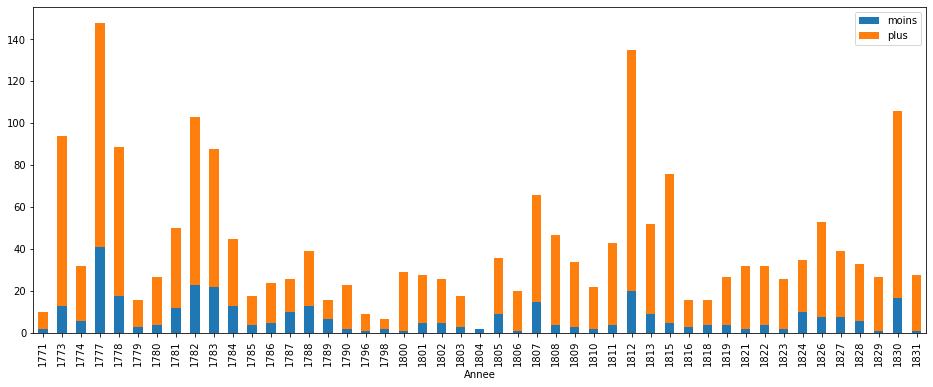

In [127]:
exp_plot.plot(kind='bar', stacked=True, figsize = (16,6))

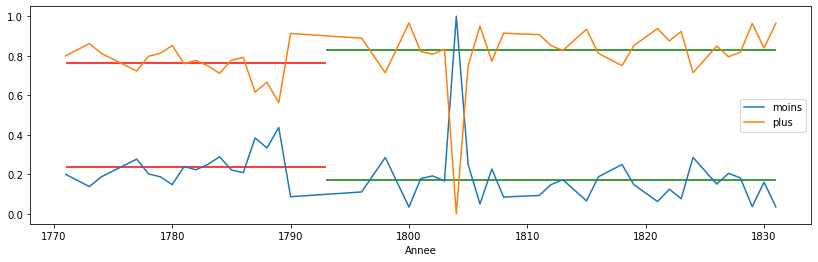

In [128]:
exp_plot['all'] = exp_plot.sum(axis=1)

for cat in ls_cat:
    exp_plot[cat] = exp_plot.apply(lambda row : row[cat]/row['all'], axis=1)
    
for cat in ls_cat:
    y1 = exp_plot[exp_plot.index<=1793][cat].mean()
    y2 = exp_plot[exp_plot.index>1793][cat].mean()
    plt.hlines(y=y1, xmin = 1771, xmax = 1793, colors = 'r')
    plt.hlines(y=y2, xmin = 1793, xmax = 1831, colors = 'g')
    exp_plot[cat].plot(kind='line', figsize = (14,4), label=cat)
    
plt.legend()

In [129]:
def get_sent_adv(df, adv, name_col = 'Eloge') :
    hdf = df[df[name_col].str.contains(adv)]
    hdf = hdf.sample(frac=1)
    hdf.reset_index(inplace = True)
    for idx in range(0,5):
        print(hdf[name_col][idx])
        print('\n')
    return hdf.head(3)
_ = get_sent_adv(sent, 'souvent')    

 Ces communications qu'il a ouvertes entre toutes les parties d’une science si vaste ; ces vues générales, que souvent même il n’indique pas, mais qui n’échappent point à un esprit attentif ; ces routes dont il s’est contenté d’ouvrir l’entrée, et d’aplanir les premiers obstacles, sont encore autant de bienfaits dont les sciences s’enrichiront, et dont la postérité jouira, en oubliant peut-être la main dont elle les aura reçus


 Le monde minéralogique se vit divisé en deux factions : les vulcaniens, qui tenaient à l'opinion de M Desmarets et attribuaient le basalte au feu ; les neptuniens, qui suivaient celle de M Werner et voulaient que cette pierre fût le produit de l'eau : et, comme il n'arrive que trop souvent dans des choses plus graves, chaque parti n'écouta plus les raisons de ses adversaires


 S’il s’apercevait aux réponses de l’auteur que c’était son approbation et non ses avis qu’on lui avait demandés, il écoutait en silence le reste de l’ouvrage, et des formules de polites

In [131]:
df_h = keep_adv(df, 'Eloge')

In [132]:
get_rep_adv(df_h, adv, df_ass, adv='adverbs')

Pre-Revolution : 
Il avait, depuis l’âge de quarante ans environ, l’habitude de prendre tous les jours du vin de quinquina : il y renonça peu de temps avant sa mort ; et ce changement fut suivi d’un dépérissement prompt et rapide
Cependant, son goût pour les sciences était toujours le même ; et jusqu’à vingt-cinq ans ou environ, il y consacra tous les moments de relâche que ses douleurs lui laissaient
Dès ce moment, sa maladie changea de caractère ; une léthargie de trois jours succéda au seul accès de délire bien caractérisé qu'il ait éprouvé ; après ce temps, un réveil de quelques minutes, pendant lequel il parut avoir toute sa raison, fut suivi d’une nouvelle léthargie qui dura quatre jours ; ni les remèdes, ni les excitatifs ne pouvaient le tirer de cet état ; à peine était-il possible de lui faire avaler quelques gouttes d’eau ; ses membres étaient mous et flexibles ; les mouvements des artères étaient insensibles ; un battement de cour qu’on avait peine à saisir, une respiration 

In [133]:
get_rep_adv(df_h, adv, df_ass, adv='adverbs', adverb='toujours', categorie='Temporalité', sorte='eternel')

Pre-Revolution : 
Il avait toujours regardé la douleur et la mort comme une suite nécessaire des lois générales de la nature, dont il serait absurde de se plaindre
Ainsi un satirique est toujours sûr de nuire, lors même qu’il parle de ce qu’il entend le moins ; c’est en partie ce qui rend ce métier si facile et si méprisable
Dans tous les problèmes sur les nombres qui se proposaient alors, on voyait toujours une solution de Frenicle à côté de celles de Descartes et de Fermat, qui avouèrent souvent que celle de Frenicle était plus élégante
Post-Revolution : 
Voulant toujours être utile aux sciences mathématiques, il fit imprimer, dès l’année suivante (1772), un troisième mémoire dans lequel il chercha à ouvrir une nouvelle route aux géomètres, en proposant des irrationnelles d’une nouvelle espèce, en montrant les suites dont ces irrationnelles sont les termes ou la somme, et en indiquant une méthode directe et générale d’y faire toutes les réductions possibles
Il était d'un caractère ti

In [154]:
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait 

In [107]:
def keep_bi_adv(tags):
    ls = []
    for tag_idx in range(len(tags)-1):
        if tags[tag_idx][1]=='ADV' and tags[tag_idx+1][1]=='ADV' :
            ls.append(tags[tag_idx][0] + ' ' + tags[tag_idx+1][0])
    return ls

sent['bigram_adv'] = sent['tags'].apply(lambda x : keep_bi_adv(x))

In [108]:
sent.bigram_adv.value_counts()

[]                       17031
[non seulement]          62   
[bien loin]              19   
[presque jamais]         16   
[presque entièrement]    13   
                         ..   
[certainement loin]      1    
[subitement presque]     1    
[très peu, peu près]     1    
[alors Ainsi]            1    
[bien réellement]        1    
Name: bigram_adv, Length: 434, dtype: int64

In [113]:
sent[sent['bigram_adv'].apply(lambda x: len(x)) > 0].shape


(736, 12)

In [114]:
sent[sent['bigram_adv'].isin(sent['bigram_adv'].value_counts()[sent['bigram_adv'].value_counts()>=5].index)].bigram_adv


0        []
1        []
2        []
4        []
5        []
         ..
17762    []
17763    []
17764    []
17765    []
17766    []
Name: bigram_adv, Length: 17282, dtype: object

In [133]:
bigram_adv = sent.explode(column = 'bigram_adv').reset_index()
bigram_adv.head(1)

index    Savant     Auteur  Annee  \
0  0      Fontaine  Condorcet  1771    

                                                               Eloge   Weird  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705  [,, ’]   

   Wrong                                                    no_sw  \
0  0      Alexis Fontaine naquit Claveison Dauphiné, l’année 1705   

                                            no_sw_no_punkt  \
0  Alexis Fontaine naquit Claveison Dauphiné  l année 1705   

                                                                                                                                                                                                 tags  \
0  [(Alexis, NAM, Alexis), (Fontaine, NAM, Fontaine), (naquit, VER:simp, naître), (Claveison, NAM, Claveison), (Dauphiné, NAM, Dauphiné), (l, VER:futu, l), (année, NOM, année), (1705, NUM, @card@)]   

                                                  Eloge_lem  \
0  Alexis Fontaine naître Claveison Dauphiné l année @card@   

                 n_v bigram_adv  
0  naître année card  NaN

In [134]:
type(bigram_adv['bigram_adv'][0])

float

In [135]:
bigram_adv['bigram_adv'] = bigram_adv['bigram_adv'].apply(lambda x : str(x).lower())
bigram_adv.groupby('bigram_adv').agg({'Eloge' : 'count'}).rename(columns={'Eloge' : 'count'}).sort_values(
    by='count', ascending=False)

count
bigram_adv                   
nan                     17031
non seulement           81   
bien loin               24   
presque jamais          17   
presque entièrement     13   
...                     ..   
ensuite successivement  1    
ensuite subitement      1    
ensuite faiblement      1    
ensemble tantôt         1    
volontiers bien         1    

[423 rows x 1 columns]

In [136]:
bigram_filt = bigram_adv.groupby('bigram_adv').agg({'Eloge' : 'count'}).rename(columns={'Eloge' : 'count'}).sort_values(
    by='count', ascending=False)

bigram_filt = bigram_filt[bigram_filt['count']>=5]

In [137]:
bigram_filt

count
bigram_adv                 
nan                   17031
non seulement         81   
bien loin             24   
presque jamais        17   
presque entièrement   13   
presque rien          12   
trop tôt              12   
trop loin             9    
jamais rien           9    
presque partout       9    
beaucoup près         9    
beaucoup mieux        9    
trop bien             9    
malheureusement trop  8    
pas beaucoup          8    
presque aussitôt      8    
presque uniquement    8    
partout ailleurs      7    
presque autant        7    
presque absolument    7    
point ici             7    
bien mal              6    
peu près              6    
trop tard             6    
trop facilement       6    
plus tard             5    
bien davantage        5    
presque toujours      5    
mieux encore          5

In [37]:
adv, df_adv = count_adverbs(sent, 'Eloge')

In [38]:
adv.shape

(1541, 2)

In [42]:
adv.sort_values(by = 'Number', ascending = False, inplace = True)

Adverb  Number
786   ne                      7252  
972   plus                    5089  
841   pas                     2240  
424   encore                  992   
1245  si                      930   
...   ..                      ...   
691   malheureusement encore  1     
692   malheureusement ne      1     
693   malheureusement non     1     
695   malheureusement si      1     
1540  évidemment plus         1     

[1541 rows x 2 columns]

In [44]:
adv = adv[adv['Number']>=5]

In [45]:
adv

Adverb  Number
0     -ci            74    
1     -ci ne         5     
5     absolument     54    
11    ailleurs       91    
24    ainsi          564   
...     ...          ...   
1522  également      205   
1533  éminemment     9     
1535  éternellement  5     
1538  étroitement    5     
1539  évidemment     8     

[416 rows x 2 columns]

In [46]:
df_ass = pd.read_csv('./../../Data/Results/Adverbs.csv')


In [51]:
adv_all = pd.merge(adv, df_ass, on = 'Adverb', how = 'left')

In [52]:
adv_all.drop('Number_y', axis=1, inplace = True)
adv_all.rename(columns = {'Number_x' : 'Number'})

Adverb  Number    Categorie    Assertivité    Temporalité  \
0    -ci            74      NaN          NaN            NaN             
1    -ci ne         5       NaN          NaN            NaN             
2    absolument     54      affirmation  certain        default value   
3    ailleurs       91      lieu         default value  default value   
4    ainsi          564     logique      default value  default value   
..     ...          ...         ...                ...            ...   
411  également      205     liaison      default value  default value   
412  éminemment     9       modal        default value  default value   
413  éternellement  5       temps        default value  eternel         
414  étroitement    5       manière      default value  default value   
415  évidemment     8       affirmation  certain        default value   

        Expérience  Description  
0    NaN            NaN          
1    NaN            NaN          
2    default value  NaN          
3    default value  NaN          
4    default value  NaN          
..             ...  ...          
411  default value  NaN          
412  default value  NaN          
413  default value  NaN          
414  default value  description  
415  default value  NaN          

[416 rows x 7 columns]

In [54]:
adv_all.fillna('default value', inplace = True)

In [56]:
adv_all[adv_all['Categorie'] == 'default value'].shape

(194, 7)

In [58]:
adv_all.to_csv('./../../Data/Results/ADV_BIG.csv', index=False)

In [155]:
sent.head()

Savant     Auteur  Annee  \
0  Fontaine  Condorcet  1771    
1  Fontaine  Condorcet  1771    
2  Fontaine  Condorcet  1771    
3  Fontaine  Condorcet  1771    
4  Fontaine  Condorcet  1771    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Eloge  \
0  Alexis Fontaine naquit à Claveison en Dauphiné, vers l’année 1705                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
1   Il avait environ vingt ans lorsque son père mourut                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2   Ses parents auraient voulu qu’il suivit les études de droit, nécessaires pour exercer une charge ; mais le style barbare des commentateurs des lois romaines et leur enthousiasme servile, dégoûtaient un homme que la nature n’avait pas destiné à se trainer sur les pas d’autrui                                                                                                                                                                                                                                                                                                                                                                                                                                                                        
3   Né avec cette rigueur d’esprit que les démonstrations seules peuvent satisfaire, et qui donne un goût exclusif pour les sciences exactes ; peu sensible au plaisir de démèler, parmi les débris des anciennes lois romaines, quelques restes de la sagesse du sénat, ces lois elles mêmes ne pouvaient être à ses yeux qu’un amas de décisions, fondées moins souvent sur la raison que sur les passions du législateur, ou sur les préjugés de son siècle D’ailleurs, la considération qu’on achète avec une charge, ne flatte guère que les hommes qui n’ont pas en eux de quoi prétendre à celle que donnent les talents ; et l’envie d’être ce qu’on appelle quelque chose, n’est bien souvent, dans un jeune homme, que l’instinct de la médiocrité   
4   Tourmenté par les sollicitations de ses parents, et encore plus par l’activité de son génie, auquel la province n’offrait 